In [1]:
import pandas as pd
import copy
import numpy as np
from datetime import datetime
import os
import re
import glob
from omegaconf import OmegaConf
from typing import List
from multiprocessing import Pool
import uncertainty_toolbox as uct
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from hydra.utils import instantiate

plt.rcParams["figure.figsize"] = [14, 5]
# sns.set(rc={'figure.figsize':(14,5)})

color_palette = {
    'MVERegression': '#1f77b4',  # Blue
    'QuantileRegression': '#ff7f0e',  # Orange
    'DKLRegression': '#2ca02c',  # Green
    'LaplaceRegression': '#d62728',  # Red
    'DeepEnsembleRegression': '#9467bd',  # Purple
    'MCDropoutRegression': '#8c564b',  # Brown
    'SWAGRegression': '#e377c2',  # Pink
    'BNN_VI_ELBO_Regression': '#7f7f7f',  # Gray
    'DER': '#bcbd22',  # Lime
    'DUERegression': '#17becf',  # Teal
    'DeterministicRegression': '#aec7e8', # Light Blue
    'ConformalQR': '#ffbb78',  # Light Orange
    "CARDRegression": "#98df8a"
}

VAR_TO_PLOT_LABEL = {
    "mae": "MAE",
    "rmse": "RMSE",
    "pred_uct": "Pred. Uncertainty",
    "coverage": "Coverage",
    "sharpness": "Sharpness",
    "nll": "NLL",
    "proportion_in_0.95_interval": "Proportion in 0.95 Interval",
    "TD": "Tropical Depression",
    "TS": "Tropical Storm",
    "H1": "Cat 1 Hurricane",
    "H2": "Cat 2 Hurricane",
    "H3": "Cat 3 Hurricane",
    "H4": "Cat 4 Hurricane",
    "H5": "Cat 5 Hurricane",
    "MVERegression": "MVE",
    "QuantileRegression": "QR",
    "DKLRegression": "DKL",
    "LaplaceRegression": "Laplace",
    "DeepEnsembleRegression": "Deep Ensemble",
    "MCDropoutRegression": "MC Dropout",
    "SWAGRegression": "SWAG",
    "BNN_VI_ELBO_Regression": "BNN VI ELBO",
    "DER": "DER",
    "DUERegression": "DUE",
    "DeterministicRegression": "Deterministic",
    "ConformalQR": "CQR",
    "CARDRegression": "CARD"
}

%load_ext autoreload
%autoreload 2

In [2]:
# specify directories to include in analysis
directories = [
    # "/p/project/hai_uqmethodbox/experiment_output/keep_reg",
    "/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0"
    # "/p/project/hai_uqmethodbox/experiment_output/digital_typhoon_check"
]
paths = [file for directory in directories for file in glob.glob(os.path.join(directory, "*", "pred*.csv"))]



# selective prediction threshold
SELECTIVE_THRESH = 9

# https://www.nhc.noaa.gov/aboutsshws.php
# wind speed is in knots in this competition
CLASS_BINS = {
    "TD": (0, 33),
    "TS": (34, 63),
    "H1": (64, 82),
    "H2": (83, 95),
    "H3": (96, 112),
    "H4": (113, 136),
    "H5": (137, np.inf),
}
BIN_EDGES = [0] + [v[1] for v in CLASS_BINS.values()]
CLASS_LABELS = list(CLASS_BINS.keys())


# choosee one type of selective prediction procedure from ["absolute", "method", "category_conditional"]
SELECTIVE_PROCEDURE = "absolute"

# TODO map them to readable names
STORM_DISPLAY_ORDER = ["all", "TD", "H1", "H3", "H5"]

DS_SPLIT = "test"

In [3]:
paths

['/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0/cyclone_QuantileRegression_01-29-2024_12-22-08-927666/preds_val.csv',
 '/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0/cyclone_QuantileRegression_01-29-2024_12-22-08-927666/preds_train.csv',
 '/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0/cyclone_QuantileRegression_01-29-2024_12-22-08-927666/preds.csv',
 '/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0/cyclone_DKLRegression_01-15-2024_08-57-18-935678/preds_val.csv',
 '/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0/cyclone_DKLRegression_01-15-2024_08-57-18-935678/preds_train.csv',
 '/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0/cyclone_DKLRegression_01-15-2024_08-57-18-935678/preds.csv',
 '/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0/cyclone_BNN_VI_ELBO_Regression_01-17-2024_14-05-18-482595/preds_val.csv',
 '/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0/cyclone_BNN_V

## Util functions

## get normaliation params

In [4]:
def get_target_normalization_params(config):
    """Get the target normalization parameters from the datamodule
    
    Args:
        config: hydra config object

    Returns:
        tuple: (target_mean, target_std)
    """
    dm = instantiate(config.datamodule)
    return dm.target_mean.item(), dm.target_std.item()

def get_normalization_params_from_df(pred_path):
    config = OmegaConf.load(os.path.join(pred_path, 'config.yaml'))
    target_mean, target_std = get_target_normalization_params(config)
    return {pred_path: {"target_mean": target_mean, "target_std": target_std}}


def get_normalization_params_from_df_wrapper(path):
    try:
        return get_normalization_params_from_df(path)
    except Exception as e:
        print(f"Error processing {path}: {e}")
        return None

def compute_normalization_params_in_parallel(paths, num_processes):
    with Pool(processes=num_processes) as pool:
        results = list(tqdm(pool.imap(get_normalization_params_from_df_wrapper, paths), total=len(paths)))
    results = {k: v for result in results if result is not None for k, v in result.items()}
    return results

num_processes = 8
dir_paths = list(set([os.path.dirname(path) for path in paths]))
NORMALIZATION_PARAMS = compute_normalization_params_in_parallel(dir_paths, num_processes)

  0%|          | 0/12 [00:00<?, ?it/s]

Num samples: 69269
Num samples: 69269
Num samples: 69269
Num samples: 69269


  8%|▊         | 1/12 [00:36<06:44, 36.79s/it]

Num samples: 69269
Num samples: 69269
Num samples: 69269


 25%|██▌       | 3/12 [00:36<01:26,  9.58s/it]

Num samples: 69269


 58%|█████▊    | 7/12 [00:41<00:19,  3.88s/it]

Num samples: 69269
Num samples: 69269
Num samples: 69269
Num samples: 69269


100%|██████████| 12/12 [01:04<00:00,  5.34s/it]


In [5]:
NORMALIZATION_PARAMS

{'/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0/cyclone_ConformalQR_01-29-2024_15-28-42-720773': {'target_mean': 50.34400939941406,
  'target_std': 26.795276641845703},
 '/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0/cyclone_DKLRegression_01-15-2024_08-57-18-935678': {'target_mean': 50.34400939941406,
  'target_std': 26.795276641845703},
 '/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0/cyclone_MVERegression_01-29-2024_11-21-56-993662': {'target_mean': 50.34400939941406,
  'target_std': 26.795276641845703},
 '/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0/cyclone_MCDropoutRegression_01-15-2024_08-57-18-935596': {'target_mean': 50.34400939941406,
  'target_std': 26.795276641845703},
 '/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0/cyclone_SWAGRegression_01-29-2024_15-31-54-221964': {'target_mean': 50.34400939941406,
  'target_std': 26.795276641845703},
 '/p/project/hai_uqmethodbox/experiment_output/min_wind_spee

## selective prediction thresholds based on validation set

In [6]:
def compute_quantile_and_save(paths: list[str], quantile: float = 0.9):
    selective_pred_dict = {}
    for path in paths:
        assert "val" in path
        df = pd.read_csv(path)

        # Compute 0.9 quantile
        if "pred_uct" in df.columns:
            TARGET_STD = NORMALIZATION_PARAMS[os.path.dirname(path)]["target_std"]
            TARGET_MEAN = NORMALIZATION_PARAMS[os.path.dirname(path)]["target_mean"]
            df["pred_uct"] = df["pred_uct"] * TARGET_STD
            df["target"] = df["target"] * TARGET_STD + TARGET_MEAN
            # threshold = np.quantile(df['pred_uct'], quantile)
            df['storm_category'] = pd.cut(df['target'], bins=BIN_EDGES, labels=CLASS_LABELS, right=False)
            if SELECTIVE_PROCEDURE == "absolute":
                # create a dict over all storm categories and fill values with absolute threshold
                thresholds = {category: SELECTIVE_THRESH for category in CLASS_LABELS}
            elif SELECTIVE_PROCEDURE == "method":
                # create a dict over all storm categories and fill values with method threshold, independent of category
                method_threshold = df["pred_uct"].quantile(quantile)
                thresholds = {category: method_threshold for category in CLASS_LABELS}
            elif SELECTIVE_PROCEDURE == "category_conditional":
                thresholds = df.groupby('storm_category', observed=False)['pred_uct'].quantile(quantile).to_dict()
        else:
            continue

        selective_pred_dict[os.path.dirname(path)] = thresholds
    return selective_pred_dict

dir_paths = [path for path in paths if "val" in path]
SELECTIVE_PRED_DICT = compute_quantile_and_save(dir_paths, 0.8)
SELECTIVE_PRED_DICT
        

{'/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0/cyclone_QuantileRegression_01-29-2024_12-22-08-927666': {'TD': 9,
  'TS': 9,
  'H1': 9,
  'H2': 9,
  'H3': 9,
  'H4': 9,
  'H5': 9},
 '/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0/cyclone_DKLRegression_01-15-2024_08-57-18-935678': {'TD': 9,
  'TS': 9,
  'H1': 9,
  'H2': 9,
  'H3': 9,
  'H4': 9,
  'H5': 9},
 '/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0/cyclone_BNN_VI_ELBO_Regression_01-17-2024_14-05-18-482595': {'TD': 9,
  'TS': 9,
  'H1': 9,
  'H2': 9,
  'H3': 9,
  'H4': 9,
  'H5': 9},
 '/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0/cyclone_SWAGRegression_01-29-2024_15-31-54-221964': {'TD': 9,
  'TS': 9,
  'H1': 9,
  'H2': 9,
  'H3': 9,
  'H4': 9,
  'H5': 9},
 '/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0/cyclone_LaplaceRegression_01-15-2024_15-32-04-140730': {'TD': 9,
  'TS': 9,
  'H1': 9,
  'H2': 9,
  'H3': 9,
  'H4': 9,
  'H5': 9},
 '/p/project/hai_uqme

In [7]:
def compute_overview_df(paths):
    pattern = r"(\d{2}-\d{2}-\d{4})"
    datetime_format = "%d-%m-%Y_%H-%M-%S-%f"
    overview_df = pd.DataFrame()
    for idx, path in enumerate(paths):
        exp_dict = {}
        conf = OmegaConf.load(os.path.join(os.path.dirname(path), "config.yaml"))
        if "post_processing" in conf:
            exp_dict["uqmethod"] = conf.post_processing["_target_"].split(".")[-1]
        else:
            exp_dict["uqmethod"] = conf.uq_method["_target_"].split(".")[-1]
        
        match = re.search(pattern, path)
        date_str = match.group(1)

        # Convert string to datetime object
        date = datetime.strptime(date_str, '%m-%d-%Y')
        # exp_dict["date"] = datetime.strptime(date_string, datetime_format)
        exp_dict["pred_path"] = path
        exp_dict["conf_path"] = path.replace("preds.csv", "config.yaml")
        exp_dict["metric_path"] = os.path.join(os.path.dirname(path), "csv_logs", "version_0", "metrics.csv")
        overview_df = pd.concat([overview_df, pd.DataFrame(exp_dict, index=[idx])])

    return overview_df

overview_df = compute_overview_df(paths)
overview_df

,uqmethod,pred_path,conf_path,metric_path
0,QuantileRegression,/p/project/hai_uqmethodbox/experiment_output/m...,/p/project/hai_uqmethodbox/experiment_output/m...,/p/project/hai_uqmethodbox/experiment_output/m...
1,QuantileRegression,/p/project/hai_uqmethodbox/experiment_output/m...,/p/project/hai_uqmethodbox/experiment_output/m...,/p/project/hai_uqmethodbox/experiment_output/m...
2,QuantileRegression,/p/project/hai_uqmethodbox/experiment_output/m...,/p/project/hai_uqmethodbox/experiment_output/m...,/p/project/hai_uqmethodbox/experiment_output/m...
3,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/m...,/p/project/hai_uqmethodbox/experiment_output/m...,/p/project/hai_uqmethodbox/experiment_output/m...
4,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/m...,/p/project/hai_uqmethodbox/experiment_output/m...,/p/project/hai_uqmethodbox/experiment_output/m...
5,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/m...,/p/project/hai_uqmethodbox/experiment_output/m...,/p/project/hai_uqmethodbox/experiment_output/m...
6,BNN_VI_ELBO_Regression,/p/project/hai_uqmethodbox/experiment_output/m...,/p/project/hai_uqmethodbox/experiment_output/m...,/p/project/hai_uqmethodbox/experiment_output/m...
7,BNN_VI_ELBO_Regression,/p/project/hai_uqmethodbox/experiment_output/m...,/p/project/hai_uqmethodbox/experiment_output/m...,/p/project/hai_uqmethodbox/experiment_output/m...
8,BNN_VI_ELBO_Regression,/p/project/hai_uqmethodbox/experiment_output/m...,/p/project/hai_uqmethodbox/experiment_output/m...,/p/project/hai_uqmethodbox/experiment_output/m...
9,SWAGRegression,/p/project/hai_uqmethodbox/experiment_output/m...,/p/project/hai_uqmethodbox/experiment_output/m...,/p/project/hai_uqmethodbox/experiment_output/m...


In [8]:
empty_result = {'accuracy': {'mae': np.nan, 'rmse': np.nan, 'mdae': np.nan, 'marpd': np.nan, 'r2': np.nan, 'corr': np.nan}, 'avg_calibration': {'rms_cal': np.nan, 'ma_cal': np.nan, 'miscal_area': np.nan}, 'sharpness': {'sharp': np.nan}, 'scoring_rule': {'nll': np.nan, 'crps': np.nan, 'check': np.nan, 'interval': np.nan}}
def compute_metrics_for_predictions(csv_path: str, selective_pred: bool, normalized: bool = False) -> pd.DataFrame:
    """Compute metrics for prediction file.

    Args:
        save_dir: path_to_csv
        selective_pred: whether or not to apply selective prediction

    Returns:
        dataframe with computed metrics
    """
    pred_df = pd.read_csv(csv_path)

    # get normalization parameters
    TARGET_MEAN, TARGET_STD = NORMALIZATION_PARAMS[os.path.dirname(csv_path)]["target_mean"], NORMALIZATION_PARAMS[os.path.dirname(csv_path)]["target_std"]
                                                              
    # unnormalize data
    if not normalized:
        pred_df["pred"] = (pred_df["pred"] * TARGET_STD) + TARGET_MEAN
        pred_df["target"] = (pred_df["target"] * TARGET_STD) + TARGET_MEAN

    # Apply the storm category
    pred_df['storm_category'] = pd.cut(pred_df['target'], bins=BIN_EDGES, labels=CLASS_LABELS, right=False)
    # count number of observations per category
    count_per_cat = pred_df.groupby("storm_category", observed=False)["pred"].count()

    if "pred_uct" in pred_df.columns:

        if not normalized:
            pred_df["pred_uct"] = pred_df["pred_uct"] * TARGET_STD

        if selective_pred:
            # Filter the DataFrame to exclude the top 10% highest values
            # pred_df = pred_df[pred_df["pred_uct"] <= SELECTIVE_THRESH]
            # pred_df = pred_df[pred_df["pred_uct"] <= SELECTIVE_PRED_DICT[os.path.dirname(csv_path)]]
            grouped = pred_df.groupby('storm_category', observed=False)

            # Apply the selective prediction filter to each group
            pred_df = grouped.apply(lambda group: group[group["pred_uct"] <= SELECTIVE_PRED_DICT[os.path.dirname(csv_path)][group.name]])

            # Reset the index of the DataFrame
            pred_df.reset_index(drop=True, inplace=True)
            # number of observations per category afterwards
            count_per_cat = pred_df.groupby("storm_category", observed=False)["pred"].count()

        if len(pred_df) > 0:  
            uq_metrics = uct.metrics.get_all_metrics(
                pred_df["pred"].values.squeeze(),
                pred_df["pred_uct"].values.squeeze(),
                pred_df["target"].values.squeeze(),
                verbose=False,
            )
        else:
            # TODO: What to do if all metrics are removed
            uq_metrics = empty_result
        # categories when predictive uncertainty is present
        uq_metric_categories = ["scoring_rule", "avg_calibration", "sharpness", "accuracy"]

    else:
        # categories when no predictive uncertainty is present
        uq_metric_categories = ["accuracy"]
        uq_metrics = {"accuracy": uct.metrics.get_all_accuracy_metrics(pred_df["pred"].values.squeeze(), pred_df["target"].values.squeeze())}

    # collect metrics
    metrics_dict = {uq_cat: uq_metrics[uq_cat] for uq_cat in uq_metric_categories}

    # mulit column df holding the results
    df = pd.DataFrame.from_dict(metrics_dict, orient="index").stack().to_frame().T

    # drop multilevel
    df.columns = df.columns.droplevel(0)

    # case if empty results have to handle manually since dict of nan just creates empty df
    if df.empty:
        # Flatten the dictionary keys
        flattened_keys = [f'{inner_key}' for outer_key, inner_dict in empty_result.items() for inner_key in inner_dict.keys()]
        # Create DataFrame
        df = pd.DataFrame(columns=flattened_keys)
        # Fill DataFrame with NaNs
        df.loc[0] = np.nan
    
    split_name = csv_path.split(os.sep)[-1].split(".")[0]
    if split_name == "preds":
        split_name = "preds_test"
    df["split"] = split_name
    df["pred_path"] = csv_path

    # count 
    count_df = pd.DataFrame(count_per_cat).transpose().reset_index()
    count_df = count_df[count_df.columns.intersection(CLASS_LABELS)]
    count_df["count_total"] = count_df.sum(axis=1)
    df = pd.concat([df, count_df], axis=1)
    return df

In [9]:
def compute_metrics_for_predictions_wrapper(path, selective_pred, normalised):
    try:
        return compute_metrics_for_predictions(path, selective_pred, normalised)
    except Exception as e:
        print(f"Error processing {path}: {e}")
        return None
    
def compute_uncertainty_df(overview_df):
    def parallel_process(paths: List[str], num_processes: int, selective_pred: bool, normalised: bool):
        # Create a multiprocessing pool with the specified number of processes
        pool = Pool(processes=num_processes)
        # Map the paths to the process_path function and execute in parallel
        # result_dfs = pool.starmap(compute_metrics_for_predictions, [(path, selective_pred, normalised) for path in paths])
        results = pool.starmap(compute_metrics_for_predictions_wrapper, [(path, selective_pred, normalised) for path in paths])
        # Filter out None results
        result_dfs = [result for result in results if result is not None]
        # Close the pool of processes
        pool.close()
        # Combine the resulting DataFrames into a single DataFrame
        combined_df = pd.concat(result_dfs, ignore_index=True)
        return combined_df

    # Assuming 'df' is your original DataFrame with the path column
    # Extract the paths from the DataFrame column
    paths = overview_df['pred_path'].tolist()

    # Specify the number of processes to use for parallel execution
    num_processes = 8  # Adjust according to your system capabilities

    # Call the parallel_process function to execute the processing in parallel
    uqmetric_df = parallel_process(paths, num_processes, selective_pred=False, normalised=False)
    selective_df = parallel_process(paths, num_processes, selective_pred=True, normalised=False)

    # merge model name column
    uqmetric_df = pd.merge(left=uqmetric_df, right=overview_df[["pred_path", "uqmethod"]], how="left", left_on="pred_path", right_on="pred_path")
    selective_df = pd.merge(left=selective_df, right=overview_df[["pred_path", "uqmethod"]], how="left", left_on="pred_path", right_on="pred_path")

    return uqmetric_df, selective_df


uq_metric_df, selective_df = compute_uncertainty_df(overview_df)

uq_metric_df, selective_df

 (1/n) Calculating accuracy metrics
 (1/n) Calculating accuracy metrics
 (1/n) Calculating accuracy metrics
 (1/n) Calculating accuracy metrics
 (1/n) Calculating accuracy metrics
 (1/n) Calculating accuracy metrics


/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


(         nll      crps     check   interval   rms_cal    ma_cal  miscal_area  \
 0   3.738282  5.468072  2.760671  27.714821  0.064029  0.058640     0.059232   
 1   3.395625  4.277960  2.160048  21.219796  0.009980  0.009390     0.009482   
 2   3.729536  5.416556  2.734450  27.867675  0.079077  0.071726     0.072451   
 3   3.719645  5.314952  2.683078  27.670245  0.018933  0.017021     0.017189   
 4   3.113498  2.201809  1.111580  14.206660  0.424238  0.373458     0.377230   
 5   3.715816  5.314433  2.682912  27.772777  0.027707  0.024721     0.024965   
 6   4.136157  7.150351  3.608783  38.713491  0.103301  0.092207     0.093139   
 7   3.492093  5.220399  2.636005  25.654355  0.019289  0.016163     0.016325   
 8   4.240018  7.092146  3.578278  39.988908  0.087965  0.077318     0.078099   
 9   3.832807  5.971144  3.014954  31.217820  0.162636  0.146316     0.147793   
 10  3.751362  5.315142  2.683665  28.605693  0.201308  0.180799     0.182626   
 11  3.776836  5.695861  2.8

In [10]:
with pd.option_context('display.max_colwidth', None):
    display(uq_metric_df[uq_metric_df["uqmethod"]=="BNN_VI_ELBO_Regression"][["pred_path","split", "rmse", "nll", "crps", "sharp"]])

,pred_path,split,rmse,nll,crps,sharp
6,/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0/cyclone_BNN_VI_ELBO_Regression_01-17-2024_14-05-18-482595/preds_val.csv,preds_val,13.224584,4.136157,7.150351,8.829856
7,/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0/cyclone_BNN_VI_ELBO_Regression_01-17-2024_14-05-18-482595/preds_train.csv,preds_train,10.853463,3.492093,5.220399,9.168925
8,/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0/cyclone_BNN_VI_ELBO_Regression_01-17-2024_14-05-18-482595/preds.csv,preds_test,13.740906,4.240018,7.092146,8.590098


# Diff Selective Prediction Effect

This Table shows the performance improvement in metrics after applying selective prediction.

In [11]:
diff_df = pd.DataFrame()

# Iterate over each column in the dataframes
for column in uq_metric_df.columns:
    # Check if the column contains numerical values
    if pd.api.types.is_numeric_dtype(uq_metric_df[column]):
        # Assign the difference to the new dataframe
        diff_df[column] = uq_metric_df[column] - selective_df[column]
    else:
        # If the column contains non-numerical values, assign the values from df1 to the new dataframe
        diff_df[column] = uq_metric_df[column]

display(diff_df[diff_df["split"]=="preds_train"][["uqmethod", "split", "nll", "sharp", "mae", "rmse", "pred_path"]])

,uqmethod,split,nll,sharp,mae,rmse,pred_path
1,QuantileRegression,preds_train,0.180471,1.630358,1.092891,1.555326,/p/project/hai_uqmethodbox/experiment_output/m...
4,DKLRegression,preds_train,0.002135,0.008957,0.032731,0.058558,/p/project/hai_uqmethodbox/experiment_output/m...
7,BNN_VI_ELBO_Regression,preds_train,0.346505,2.238536,3.070068,5.183181,/p/project/hai_uqmethodbox/experiment_output/m...
10,SWAGRegression,preds_train,0.626424,6.531556,4.312896,6.090928,/p/project/hai_uqmethodbox/experiment_output/m...
13,LaplaceRegression,preds_train,NaN,NaN,NaN,NaN,/p/project/hai_uqmethodbox/experiment_output/m...
16,DeterministicRegression,preds_train,NaN,NaN,0.000000,0.000000,/p/project/hai_uqmethodbox/experiment_output/m...
19,ConformalQR,preds_train,0.339018,2.973177,2.088953,2.754741,/p/project/hai_uqmethodbox/experiment_output/m...
22,DUERegression,preds_train,NaN,NaN,NaN,NaN,/p/project/hai_uqmethodbox/experiment_output/m...
25,DeepEnsembleRegression,preds_train,0.661876,7.097967,4.768476,6.898682,/p/project/hai_uqmethodbox/experiment_output/m...
28,MCDropoutRegression,preds_train,NaN,NaN,NaN,NaN,/p/project/hai_uqmethodbox/experiment_output/m...


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, 'QuantileRegression'),
  Text(1, 0, 'DKLRegression'),
  Text(2, 0, 'BNN_VI_ELBO_Regression'),
  Text(3, 0, 'SWAGRegression'),
  Text(4, 0, 'LaplaceRegression'),
  Text(5, 0, 'DeterministicRegression'),
  Text(6, 0, 'ConformalQR'),
  Text(7, 0, 'DUERegression'),
  Text(8, 0, 'DeepEnsembleRegression'),
  Text(9, 0, 'MCDropoutRegression'),
  Text(10, 0, 'DER'),
  Text(11, 0, 'MVERegression')])

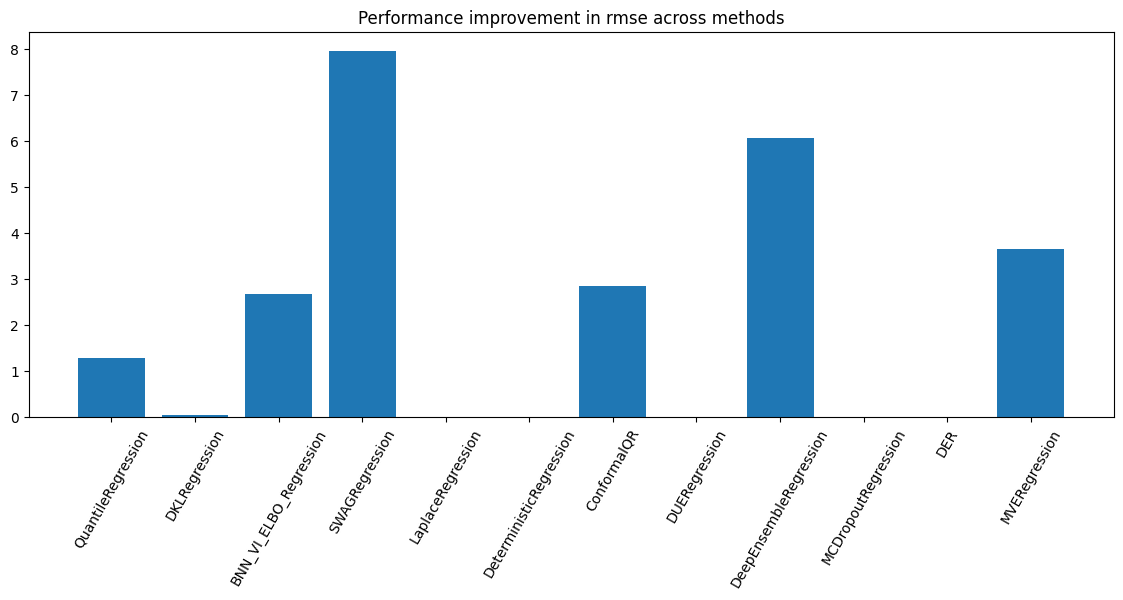

In [12]:
metric = "rmse"
diff_train = diff_df[diff_df["split"]=="preds_train"].reset_index(drop=True)
diff_test = diff_df[diff_df["split"]=="preds_val"].reset_index(drop=True)
fig, ax = plt.subplots(1)
ax.bar(diff_test["uqmethod"].values, diff_test[metric].values)
plt.title(f"Performance improvement in {metric} across methods")
plt.xticks(rotation=60)

In [13]:
uq_metric_df

,nll,crps,check,interval,rms_cal,ma_cal,miscal_area,sharp,mae,rmse,...,pred_path,TD,TS,H1,H2,H3,H4,H5,count_total,uqmethod
0,3.738282,5.468072,2.760671,27.714821,0.064029,0.058640,0.059232,8.434976,7.648554,9.961395,...,/p/project/hai_uqmethodbox/experiment_output/m...,2790,4682,1625,543,528,434,0,10602,QuantileRegression
1,3.395625,4.277960,2.160048,21.219796,0.009980,0.009390,0.009482,8.153571,6.013775,8.060154,...,/p/project/hai_uqmethodbox/experiment_output/m...,17982,24503,5833,2527,2742,2018,411,56016,QuantileRegression
2,3.729536,5.416556,2.734450,27.867675,0.079077,0.071726,0.072451,7.984429,7.521979,10.124168,...,/p/project/hai_uqmethodbox/experiment_output/m...,16277,18851,4275,1572,1574,939,147,43635,QuantileRegression
3,3.719645,5.314952,2.683078,27.670245,0.018933,0.017021,0.017189,8.783760,7.282537,9.847224,...,/p/project/hai_uqmethodbox/experiment_output/m...,3008,4881,1062,375,479,370,93,10268,DKLRegression
4,3.113498,2.201809,1.111580,14.206660,0.424238,0.373458,0.377230,8.786180,1.377175,1.828546,...,/p/project/hai_uqmethodbox/experiment_output/m...,17659,24274,6585,2722,2806,2091,296,56433,DKLRegression
5,3.715816,5.314433,2.682912,27.772777,0.027707,0.024721,0.024965,8.780457,7.227474,9.813804,...,/p/project/hai_uqmethodbox/experiment_output/m...,16277,18851,4275,1572,1574,939,147,43635,DKLRegression
6,4.136157,7.150351,3.608783,38.713491,0.103301,0.092207,0.093139,8.829856,9.705670,13.224584,...,/p/project/hai_uqmethodbox/experiment_output/m...,3973,5690,1624,653,399,292,41,12672,BNN_VI_ELBO_Regression
7,3.492093,5.220399,2.636005,25.654355,0.019289,0.016163,0.016325,9.168925,7.381969,10.853463,...,/p/project/hai_uqmethodbox/experiment_output/m...,16446,23291,5857,2401,2893,2181,359,53428,BNN_VI_ELBO_Regression
8,4.240018,7.092146,3.578278,39.988908,0.087965,0.077318,0.078099,8.590098,9.485988,13.740906,...,/p/project/hai_uqmethodbox/experiment_output/m...,16277,18851,4275,1572,1574,939,147,43635,BNN_VI_ELBO_Regression
9,3.832807,5.971144,3.014954,31.217820,0.162636,0.146316,0.147793,15.606950,7.903447,10.506093,...,/p/project/hai_uqmethodbox/experiment_output/m...,3091,5094,1397,562,665,625,90,11524,SWAGRegression


The number of samples being removed per category as a percentage.

In [14]:
sample_remain_pct = (uq_metric_df[CLASS_LABELS+["count_total"]] - selective_df[CLASS_LABELS+["count_total"]]) / uq_metric_df[CLASS_LABELS+["count_total"]]
sample_remain_pct.insert(0, ("split"), uq_metric_df["split"])
sample_remain_pct.insert(0, ("UQ Method"), uq_metric_df["uqmethod"])

/tmp/ipykernel_30485/71057437.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([VAR_TO_PLOT_LABEL[label.get_text()] for label in ax.get_xticklabels()])


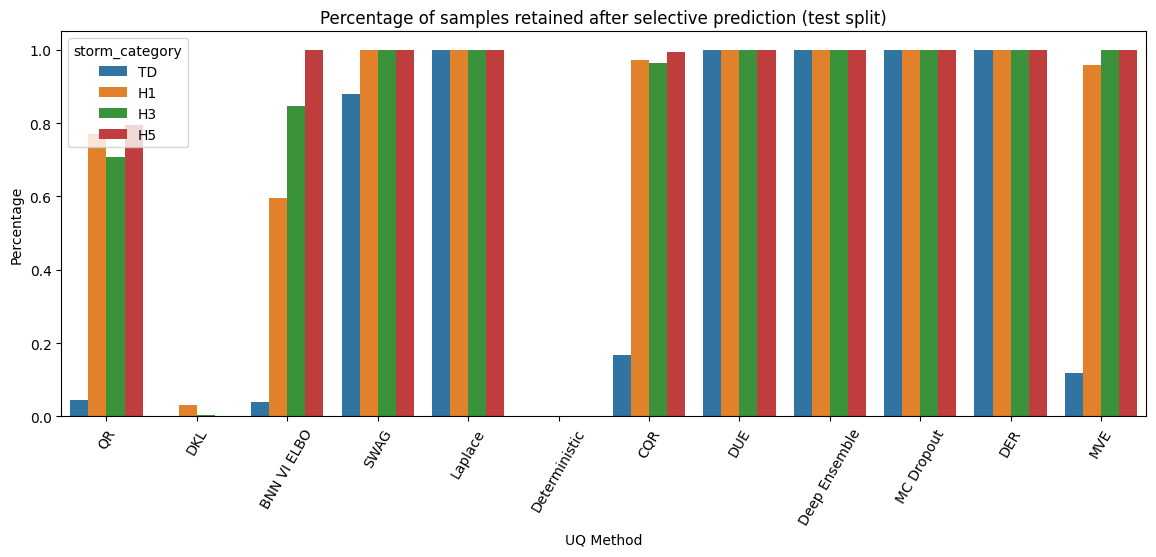

In [15]:
def plot_sample_percentage(sample_remain_pct, split_type):
    # Filter the DataFrame based on the split type
    count = sample_remain_pct[sample_remain_pct["split"]==f"preds_{split_type}"].reset_index(drop=True)
    
    # Melt the DataFrame to long format
    count = pd.melt(count, id_vars="UQ Method", value_vars=CLASS_LABELS+["count_total"], var_name="storm_category")

    count = count[count["storm_category"].isin(STORM_DISPLAY_ORDER)]
    
    # Create the bar plot
    fig, ax = plt.subplots(1)
    sns.barplot(x="UQ Method", y="value", hue="storm_category", data=count, ax=ax)
    plt.ylabel("Percentage")
    plt.title(f"Percentage of samples retained after selective prediction ({split_type} split)")
    plt.xticks(rotation=60)

    # Set the x-tick labels using the VAR_TO_PLOT_LABEL dictionary
    ax.set_xticklabels([VAR_TO_PLOT_LABEL[label.get_text()] for label in ax.get_xticklabels()])

    plt.show()

# Call the function with 'train' or 'val' as the argument
plot_sample_percentage(sample_remain_pct, DS_SPLIT)

# All preds in a single DF

In [26]:
overview_df["split"] = overview_df["pred_path"].str.split(os.sep, expand=True)[7]

all_test_pred_df = []
for idx, row in overview_df.iterrows():
    pred_df = pd.read_csv(row["pred_path"])
    pred_df["uqmethod"] = row["uqmethod"]
    if row["split"] == "preds.csv":
        pred_df["split"] = "preds_test"
    else:
        pred_df["split"] = row["split"].split(".")[0]

    pred_df["pred_path"] = row["pred_path"]
    all_test_pred_df.append(pred_df)

from scipy import stats
# test_df = overview_df[overview_df["split"]=="preds"]

all_test_pred_df = pd.concat(all_test_pred_df, ignore_index=True)

def get_normalization_params(group):
    pred_path = group['pred_path'].iloc[0]
    TARGET_MEAN, TARGET_STD = NORMALIZATION_PARAMS[os.path.dirname(pred_path)]["target_mean"], NORMALIZATION_PARAMS[os.path.dirname(pred_path)]["target_std"]
    group['target_mean'] = TARGET_MEAN
    group['target_std'] = TARGET_STD
    return group

all_test_pred_df = all_test_pred_df.groupby('pred_path').apply(get_normalization_params)

# normalize
all_test_pred_df["pred"] = (all_test_pred_df["pred"] * all_test_pred_df["target_std"]) + all_test_pred_df["target_mean"]
all_test_pred_df["target"] = (all_test_pred_df["target"] * all_test_pred_df["target_std"]) + all_test_pred_df["target_mean"]
all_test_pred_df["pred_uct"] = all_test_pred_df["pred_uct"] * all_test_pred_df["target_std"]

all_test_pred_df['storm_category'] = pd.cut(all_test_pred_df['target'], bins=BIN_EDGES, labels=CLASS_LABELS, right=False)
all_test_pred_df["mse"] = (all_test_pred_df["pred"] - all_test_pred_df["target"])**2
all_test_pred_df["mae"] = np.abs(all_test_pred_df["pred"] - all_test_pred_df["target"])
all_test_pred_df["nll"] = -1 * stats.norm.logpdf(all_test_pred_df["pred"] - all_test_pred_df["target"], scale=all_test_pred_df["pred_uct"])

# date
pattern = r"(\d{2}-\d{2}-\d{4}_\d{2}-\d{2}-\d{6})"

# Extract dates and create a new column
all_test_pred_df['date'] = all_test_pred_df['pred_path'].str.extract(pattern)

# Convert the new_date_column to datetime format
all_test_pred_df['date'] = pd.to_datetime(all_test_pred_df['date'], format='%m-%d-%Y_%H-%M')

all_test_pred_df = all_test_pred_df.reset_index(drop=True)
all_test_pred_df = all_test_pred_df.dropna(subset=["mse", "mae"], how='any')
all_test_pred_df

,pred,pred_uct,lower_quant,upper_quant,aleatoric_uct,target,uqmethod,split,pred_path,epistemic_uct,target_mean,target_std,storm_category,mse,mae,nll,date
0,24.821084,7.084931,NaN,NaN,NaN,33.000000,BNN_VI_ELBO_Regression,preds_test,/p/project/hai_uqmethodbox/experiment_output/m...,0.264410,50.344009,26.795277,TS,66.894672,8.178916,3.543240,NaT
1,24.618835,7.105170,NaN,NaN,NaN,33.000000,BNN_VI_ELBO_Regression,preds_test,/p/project/hai_uqmethodbox/experiment_output/m...,0.265165,50.344009,26.795277,TS,70.243925,8.381165,3.575474,NaT
2,24.475273,7.100180,NaN,NaN,NaN,32.000001,BNN_VI_ELBO_Regression,preds_test,/p/project/hai_uqmethodbox/experiment_output/m...,0.264979,50.344009,26.795277,TD,56.621521,7.524727,3.440640,NaT
3,24.386763,7.074877,NaN,NaN,NaN,32.000001,BNN_VI_ELBO_Regression,preds_test,/p/project/hai_uqmethodbox/experiment_output/m...,0.264034,50.344009,26.795277,TD,57.961384,7.613237,3.454478,NaT
4,24.456357,7.074541,NaN,NaN,NaN,31.000000,BNN_VI_ELBO_Regression,preds_test,/p/project/hai_uqmethodbox/experiment_output/m...,0.264022,50.344009,26.795277,TD,42.819262,6.543643,3.303213,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1320694,39.049723,15.035773,NaN,NaN,0.559586,40.000000,SWAGRegression,preds_val,/p/project/hai_uqmethodbox/experiment_output/m...,0.041672,50.344009,26.795277,TS,0.903027,0.950277,3.631368,NaT
1320695,41.247256,12.386063,NaN,NaN,0.460889,51.000000,SWAGRegression,preds_val,/p/project/hai_uqmethodbox/experiment_output/m...,0.035416,50.344009,26.795277,TS,95.116010,9.752744,3.745507,NaT
1320696,37.192006,11.992295,NaN,NaN,0.445584,35.000000,SWAGRegression,preds_val,/p/project/hai_uqmethodbox/experiment_output/m...,0.041925,50.344009,26.795277,TS,4.804890,2.192006,3.419908,NaT
1320697,40.081452,16.197011,NaN,NaN,0.603995,44.000000,SWAGRegression,preds_val,/p/project/hai_uqmethodbox/experiment_output/m...,0.024021,50.344009,26.795277,TS,15.355014,3.918547,3.733030,NaT


In [27]:
cqr = all_test_pred_df[all_test_pred_df["uqmethod"]=="ConformalQR"]
print(cqr.shape)
cqr[cqr["pred_uct"]<0]

(110359, 17)


,pred,pred_uct,lower_quant,upper_quant,aleatoric_uct,target,uqmethod,split,pred_path,epistemic_uct,target_mean,target_std,storm_category,mse,mae,nll,date


In [28]:
all_test_pred_df[all_test_pred_df["pred_uct"].isna()]["uqmethod"].unique()

array(['DeterministicRegression'], dtype=object)

In [29]:
laplace_df = all_test_pred_df[all_test_pred_df["uqmethod"]=="LaplaceRegression"]
abs(laplace_df["target_mean"] - laplace_df["target"]).std() / 26.795276641845703

0.5934949220700939

## Dataframe with Metrics per Category

In [30]:
group_cols = ["uqmethod", "pred_path", "storm_category"]
category_df = all_test_pred_df.groupby(by=group_cols, observed=False)[["mse", "mae", "nll", "pred_uct"]].mean()
category_df.reset_index(inplace=True)
category_df.rename(columns={"pred_uct": "sharpness"}, inplace=True)
category_df["rmse"] = category_df["mse"] ** 0.5
category_df['split'] = category_df['pred_path'].str.rsplit('/', n=1).str[-1].str.rsplit(".").str[0]
category_df['split'] = category_df['split'].replace("preds", "preds_test")
category_df["contains"] = [x[0] in x[1] for x in zip(category_df['uqmethod'], category_df['pred_path'])]
category_df = category_df[category_df["contains"]==True]

category_df = category_df[~((category_df['uqmethod'] == 'MCDropoutRegression') & category_df['rmse'].isna())]
category_df = category_df[~((category_df['uqmethod'] == 'DKLRegression') & category_df['rmse'].isna())]
# category_df = category_df[~((category_df['uqmethod'] == 'BaseModel') & category_df['rmse'].isna())]

del category_df["contains"]
# compute other metrics of interest
quantile = 0.95
result = all_test_pred_df[all_test_pred_df["uqmethod"]!="DeterministicRegression"].groupby(group_cols, observed=False).apply(lambda x: uct.get_proportion_in_interval(x["pred"].values, x['pred_uct'].values, x['target'].values, quantile=quantile)).reset_index()
result.rename(columns={0: f"proportion_in_{quantile}_interval"}, inplace=True)

category_df = pd.merge(category_df, result, how="left", left_on=group_cols, right_on=group_cols)

columns_to_check = ["mse", "mae", "nll", "sharpness", "rmse"]
category_df = category_df.dropna(subset=columns_to_check)
category_df

,uqmethod,pred_path,storm_category,mse,mae,nll,sharpness,rmse,split,proportion_in_0.95_interval
0,BNN_VI_ELBO_Regression,/p/project/hai_uqmethodbox/experiment_output/m...,TD,57.133195,5.689778,3.404816,6.737422,7.558650,preds_test,0.929287
1,BNN_VI_ELBO_Regression,/p/project/hai_uqmethodbox/experiment_output/m...,TS,83.917508,7.235246,3.731177,7.802064,9.160650,preds_test,0.878892
2,BNN_VI_ELBO_Regression,/p/project/hai_uqmethodbox/experiment_output/m...,H1,316.098208,15.342496,5.592821,10.091708,17.779151,preds_test,0.624327
3,BNN_VI_ELBO_Regression,/p/project/hai_uqmethodbox/experiment_output/m...,H2,606.546209,22.176314,6.934250,11.915307,24.628159,preds_test,0.524809
4,BNN_VI_ELBO_Regression,/p/project/hai_uqmethodbox/experiment_output/m...,H3,996.010017,27.837567,9.168894,13.011754,31.559626,preds_test,0.475222
...,...,...,...,...,...,...,...,...,...,...
247,SWAGRegression,/p/project/hai_uqmethodbox/experiment_output/m...,H1,172.283193,10.773919,4.088347,17.834916,13.125669,preds_val,0.990694
248,SWAGRegression,/p/project/hai_uqmethodbox/experiment_output/m...,H2,310.631610,14.471609,4.286655,18.498985,17.624744,preds_val,0.967972
249,SWAGRegression,/p/project/hai_uqmethodbox/experiment_output/m...,H3,186.697739,10.379534,4.071361,17.719133,13.663738,preds_val,0.984962
250,SWAGRegression,/p/project/hai_uqmethodbox/experiment_output/m...,H4,195.742343,10.840643,4.104024,18.098005,13.990795,preds_val,0.985600


In [31]:
with pd.option_context('display.max_colwidth', None):
    display(category_df[category_df["uqmethod"]=="DKLRegression"])


,uqmethod,pred_path,storm_category,mse,mae,nll,sharpness,rmse,split,proportion_in_0.95_interval
63,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0/cyclone_DKLRegression_01-15-2024_08-57-18-935678/preds.csv,TD,51.788405,5.229451,3.426767,8.770066,7.196416,preds_test,0.965657
64,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0/cyclone_DKLRegression_01-15-2024_08-57-18-935678/preds.csv,TS,84.745142,7.223524,3.640422,8.782419,9.205712,preds_test,0.937404
65,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0/cyclone_DKLRegression_01-15-2024_08-57-18-935678/preds.csv,H1,172.656096,10.405115,4.213436,8.804551,13.139867,preds_test,0.811930
66,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0/cyclone_DKLRegression_01-15-2024_08-57-18-935678/preds.csv,H2,187.868408,10.833199,4.308757,8.794461,13.706510,preds_test,0.797074
67,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0/cyclone_DKLRegression_01-15-2024_08-57-18-935678/preds.csv,H3,265.714173,11.895982,4.815182,8.779597,16.300741,preds_test,0.777637
68,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0/cyclone_DKLRegression_01-15-2024_08-57-18-935678/preds.csv,H4,253.095716,11.754220,4.734693,8.781554,15.908982,preds_test,0.778488
69,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0/cyclone_DKLRegression_01-15-2024_08-57-18-935678/preds.csv,H5,494.587482,19.096858,6.297895,8.792236,22.239323,preds_test,0.523810
70,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0/cyclone_DKLRegression_01-15-2024_08-57-18-935678/preds_train.csv,TD,1.386588,0.932140,3.099338,8.770440,1.177535,preds_train,1.000000
71,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0/cyclone_DKLRegression_01-15-2024_08-57-18-935678/preds_train.csv,TS,3.348003,1.377563,3.113174,8.784149,1.829755,preds_train,0.999959
72,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0/cyclone_DKLRegression_01-15-2024_08-57-18-935678/preds_train.csv,H1,5.546428,1.860836,3.132754,8.832407,2.355086,preds_train,0.999848


In [32]:
# Make latex table
def generate_latex_table(category_df, split_type):
    metric_columns = ["rmse", "nll"]

    table_labels = category_df["storm_category"].unique()
    columns = pd.MultiIndex.from_product([table_labels, metric_columns])
    combined_df = pd.DataFrame(columns=columns)

    latex_df = category_df[category_df["split"]==f"preds_{split_type}"]

    # Replace the uqmethod values using the VAR_TO_PLOT_LABEL dictionary
    latex_df["uqmethod"] = latex_df["uqmethod"].apply(lambda x: VAR_TO_PLOT_LABEL[x] if x in VAR_TO_PLOT_LABEL else x)


    for split in table_labels:
        split_df = latex_df[latex_df["storm_category"]==split]
        for metric in metric_columns:
            combined_df[(split, metric)] = split_df[metric].values

    combined_df.insert(0, ("", "uqmethod"), latex_df["uqmethod"].unique())
    combined_df = combined_df.round(3)

    latex_table = as_latex_output(combined_df)
    return latex_table

def as_latex_output(combined_df):
    combined_df = combined_df.round(3)
    # print(combined_df.max())
    max_values = combined_df.max()
    min_values = combined_df.min()
    latex_output = combined_df.to_latex(escape=False, index=False, float_format="%.3f")

    for column in max_values.index:
        if "diff" in column:
            latex_output = latex_output.replace(
                str(max_values[column]), "\\textbf{" + str(max_values[column]) + "}"
            )
        else:
            latex_output = latex_output.replace(
                str(min_values[column]), "\\textbf{" + str(min_values[column]) + "}"
            )
        # latex_column = column.replace("_", "\\_")
        # latex_output = latex_output.replace(column, latex_column)

    latex_output = latex_output.replace("_", "\\_")
    latex_output = latex_output.replace("\multicolumn{3}{r}", "\multicolumn{3}{c}")
    latex_output = latex_output.replace("rmse", "rmse $\downarrow$")
    latex_output = latex_output.replace("nll", "nll $\downarrow$")
    # latex_output = latex_output.replace("down", "up")
    latex_output = latex_output.replace("default", "default $\downarrow$")
    latex_output = latex_output.replace("selective", "selective $\downarrow$")
    latex_output = latex_output.replace("Model", "")
    latex_output = latex_output.replace("{lrrrrrrrrrr}", "l|cc|cc|cc|cc|cc")
    latex_output = latex_output.replace("\multicolumn{2}{r}", "\multicolumn{2}{c}")
    latex_output = latex_output.replace("\textbf{BNN\_VI\_ELBO}", "BNN\_VI\_ELBO")
    return latex_output

latex_table = generate_latex_table(category_df, DS_SPLIT)
print(latex_table)

\begin{tabular}{lrrrrrrrrrrrrrr}
\toprule
 & \multicolumn{2}{c}{TD} & \multicolumn{2}{c}{TS} & \multicolumn{2}{c}{H1} & \multicolumn{2}{c}{H2} & \multicolumn{2}{c}{H3} & \multicolumn{2}{c}{H4} & \multicolumn{2}{c}{H5} \\
uqmethod & rmse $\downarrow$ & nll $\downarrow$ & rmse $\downarrow$ & nll $\downarrow$ & rmse $\downarrow$ & nll $\downarrow$ & rmse $\downarrow$ & nll $\downarrow$ & rmse $\downarrow$ & nll $\downarrow$ & rmse $\downarrow$ & nll $\downarrow$ & rmse $\downarrow$ & nll $\downarrow$ \\
\midrule
\textbf{BNN VI ELBO} & 7.559 & 3.405 & 9.161 & 3.731 & 17.779 & 5.593 & 24.628 & 6.934 & 31.560 & 9.169 & 39.085 & 8.908 & 53.452 & 11.228 \\
CQR & 7.515 & \textbf{3.251} & 9.188 & 3.669 & 14.369 & 4.258 & 15.301 & 4.238 & 16.933 & 4.354 & \textbf{15.112} & \textbf{4.153} & 17.560 & 4.475 \\
DER & 8.173 & 4.208 & \textbf{8.228} & 4.403 & 14.504 & 4.562 & 16.374 & 4.592 & 19.573 & 4.630 & 19.310 & 4.619 & 22.423 & 4.670 \\
DKL & \textbf{7.196} & 3.427 & 9.206 & \textbf{3.64}0 & 13.

/tmp/ipykernel_30485/477482455.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  latex_df["uqmethod"] = latex_df["uqmethod"].apply(lambda x: VAR_TO_PLOT_LABEL[x] if x in VAR_TO_PLOT_LABEL else x)


['TD', 'H1', 'H3', 'H5']
Categories (4, object): ['TD' < 'H1' < 'H3' < 'H5']


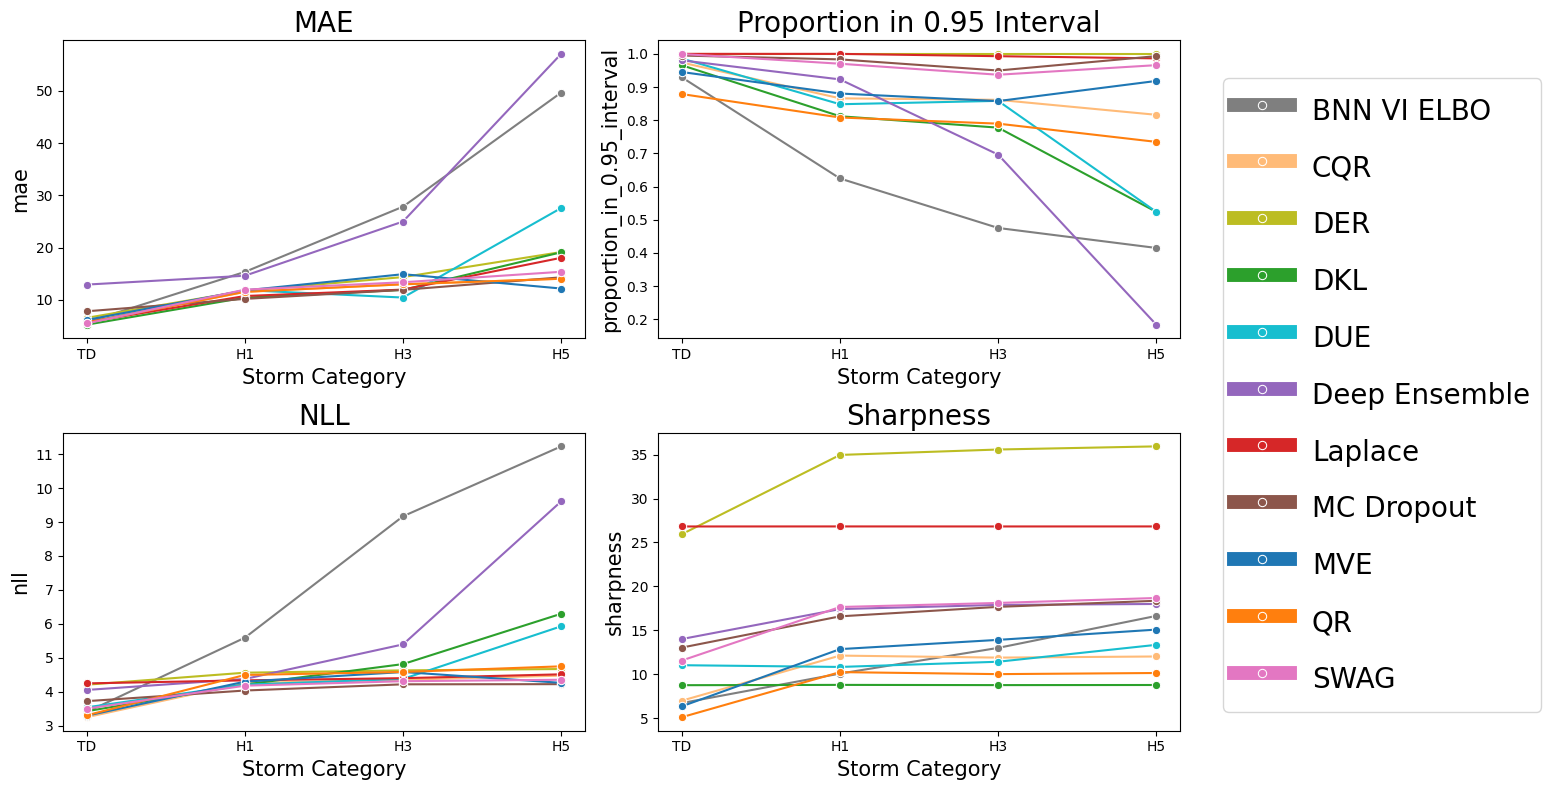

In [42]:
def plot_metrics_by_category(category_df, split_type):
    plot_cat_df = category_df[category_df["split"] == f"preds_{split_type}"]

    # plot per category
    fig, axes = plt.subplots(2, 2, figsize=(12,8))

    # Assuming 'category' is the column used for x-axis and 'metrics' are the columns to be plotted
    metrics = ["mae", "proportion_in_0.95_interval", "nll", "sharpness"]

    plot_cat_df = plot_cat_df[plot_cat_df["uqmethod"]!="DERModel"]

    plot_cat_df = plot_cat_df[plot_cat_df["storm_category"].isin(STORM_DISPLAY_ORDER)]
    plot_cat_df["storm_category"] = plot_cat_df["storm_category"].cat.remove_unused_categories()
    print(plot_cat_df["storm_category"].unique())

    # Loop through the subplots
    for i, metric in enumerate(metrics):
        row = i // 2
        col = i % 2

        # Create the sns plot
        sns.lineplot(x='storm_category', y=metric, hue="uqmethod", data=plot_cat_df, ax=axes[row, col], marker="o", palette=color_palette)

        # Add title and increase the size
        axes[row, col].set_title(f'{VAR_TO_PLOT_LABEL[metric]}', fontsize=20)

        # Increase the size of the x and y labels
        axes[row, col].set_xlabel('Storm Category', fontsize=15)
        axes[row, col].set_ylabel(metric, fontsize=15)

        # Increase the size of the x and y ticks
        axes[row, col].tick_params(axis='both', which='major', labelsize=10)

    # set the linewidths to the copies
    handles, labels = axes[0,0].get_legend_handles_labels()
    [ha.set_linewidth(10) for ha in handles]

    # Replace the labels using the VAR_TO_PLOT_LABEL dictionary
    labels = [VAR_TO_PLOT_LABEL[label] if label in VAR_TO_PLOT_LABEL else label for label in labels]

    # Increase the size of the legend labels
    fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.3, 0.5), fontsize=20, handleheight=2)

    # Remove individual legends
    for ax in axes.flat:
        ax.get_legend().remove()

    # Adjust layout
    plt.tight_layout()

    # Show the plots
    plt.show()

# Call the function with 'train' or 'val' as the argument
plot_metrics_by_category(category_df, DS_SPLIT)

# Tables

In [43]:
def generate_latex_table(uq_metric_df, selective_df, split_type):
    category_columns = ["rmse", "nll"]
    columns = pd.MultiIndex.from_product([[split_type], category_columns, ["default", "selective", "diff"]])
    combined_df = pd.DataFrame(columns=columns)

    if "train" in split_type.lower():
        table_uq_df = uq_metric_df[uq_metric_df["split"]=="preds_train"]
        table_selective_df = selective_df[selective_df["split"]=="preds_train"]
    else:
        table_uq_df = uq_metric_df[uq_metric_df["split"]=="preds_val"]
        table_selective_df = selective_df[selective_df["split"]=="preds_val"]

    table_uq_df = table_uq_df.groupby("uqmethod")[category_columns].mean().reset_index()
    table_selective_df = table_selective_df.groupby("uqmethod")[category_columns].mean().reset_index()

    # Replace the uqmethod values using the VAR_TO_PLOT_LABEL dictionary
    table_uq_df["uqmethod"] = table_uq_df["uqmethod"].apply(lambda x: VAR_TO_PLOT_LABEL[x] if x in VAR_TO_PLOT_LABEL else x)

    for metric in category_columns:
        combined_df[(split_type, metric, "default")] = table_uq_df[metric]
        combined_df[(split_type, metric, "selective")] = table_selective_df[metric]
        combined_df[(split_type, metric, "diff")] = table_uq_df[metric] - table_selective_df[metric]

    combined_df.insert(0, ("", "", "uqmethod"), table_uq_df["uqmethod"])
    combined_df = combined_df.round(4)

    latex_table = as_latex_output(combined_df, category_columns)
    return latex_table

def as_latex_output(combined_df, category_columns):
    combined_df = combined_df.round(4)
    max_values = combined_df.max()
    min_values = combined_df.min()
    latex_output = combined_df.to_latex(escape=False, index=False, float_format="%.4f")

    for column in max_values.index:
        if "diff" in column:
            latex_output = latex_output.replace(
                str(max_values[column]), "\\textbf{" + str(max_values[column]) + "}"
            )
        else:
            latex_output = latex_output.replace(
                str(min_values[column]), "\\textbf{" + str(min_values[column]) + "}"
            )

    # Replace the category_columns values using the VAR_TO_PLOT_LABEL dictionary
    for column in category_columns:
        latex_output = latex_output.replace(column, VAR_TO_PLOT_LABEL[column] if column in VAR_TO_PLOT_LABEL else column)

    latex_output = latex_output.replace("_", "\\_")
    latex_output = latex_output.replace("\multicolumn{3}{r}", "\multicolumn{3}{c}")
    latex_output = latex_output.replace("diff", "diff $\downarrow$")
    latex_output = latex_output.replace("down", "up")
    latex_output = latex_output.replace("default", "default $\downarrow$")
    latex_output = latex_output.replace("selective", "selective $\downarrow$")
    latex_output = latex_output.replace("Model", "")
    latex_output = latex_output.replace("{lrrrrrrrrrrrr}", "{lccc|ccc|ccc|ccc}")
    latex_output = latex_output.replace("\multicolumn{6}{r}{Train}", "\multicolumn{6}{c}{Train}")
    latex_output = latex_output.replace("\multicolumn{6}{r}{Test}", "\multicolumn{6}{c}{Test}")
    return latex_output

latex_table = generate_latex_table(uq_metric_df, selective_df, DS_SPLIT)
print(latex_table)

\begin{tabular}{lrrrrrr}
\toprule
 & \multicolumn{6}{r}{test} \\
 & \multicolumn{3}{c}{RMSE} & \multicolumn{3}{c}{NLL} \\
uqmethod & default $\downarrow$ & selective $\downarrow$ & diff $\uparrow$ & default $\downarrow$ & selective $\downarrow$ & diff $\uparrow$ \\
\midrule
\textbf{BNN VI ELBO} & 13.2246 & 10.5487 & 2.6759 & 4.1362 & 3.9433 & 0.1929 \\
CQR & 8.1544 & 5.3011 & 2.8533 & \textbf{3.4335} & \textbf{3.0856} & 0.3479 \\
DER & 10.8861 & NaN & NaN & 4.3869 & NaN & NaN \\
DKL & 9.8472 & 9.8080 & 0.0392 & 3.7196 & 3.7151 & 0.0045 \\
DUE & 10.0617 & NaN & NaN & 3.7257 & NaN & NaN \\
Deep Ensemble & 8.5794 & \textbf{2.5181} & 6.0613 & 3.7854 & 3.1480 & 0.6374 \\
Deterministic & 9.1414 & 9.1414 & 0.0000 & NaN & NaN & NaN \\
Laplace & \textbf{5.7876} & NaN & NaN & 4.2315 & NaN & NaN \\
MC Dropout & 10.7458 & NaN & NaN & 3.8504 & NaN & NaN \\
MVE & 11.0408 & 7.3735 & 3.6673 & 3.7236 & 3.3578 & 0.3658 \\
QR & 9.9614 & 8.6706 & 1.2908 & 3.7383 & 3.6371 & 0.1012 \\
SWAG & 10.5061 & 2.532

## Metric Computation per Category

In [44]:
category_columns = ["rmse", "nll", "sharpness"]
splits = [""]

columns = pd.MultiIndex.from_product([splits, category_columns, ["default", "selective", "diff"]])
combined_df = pd.DataFrame(columns=columns)


## Error Analysis per Category

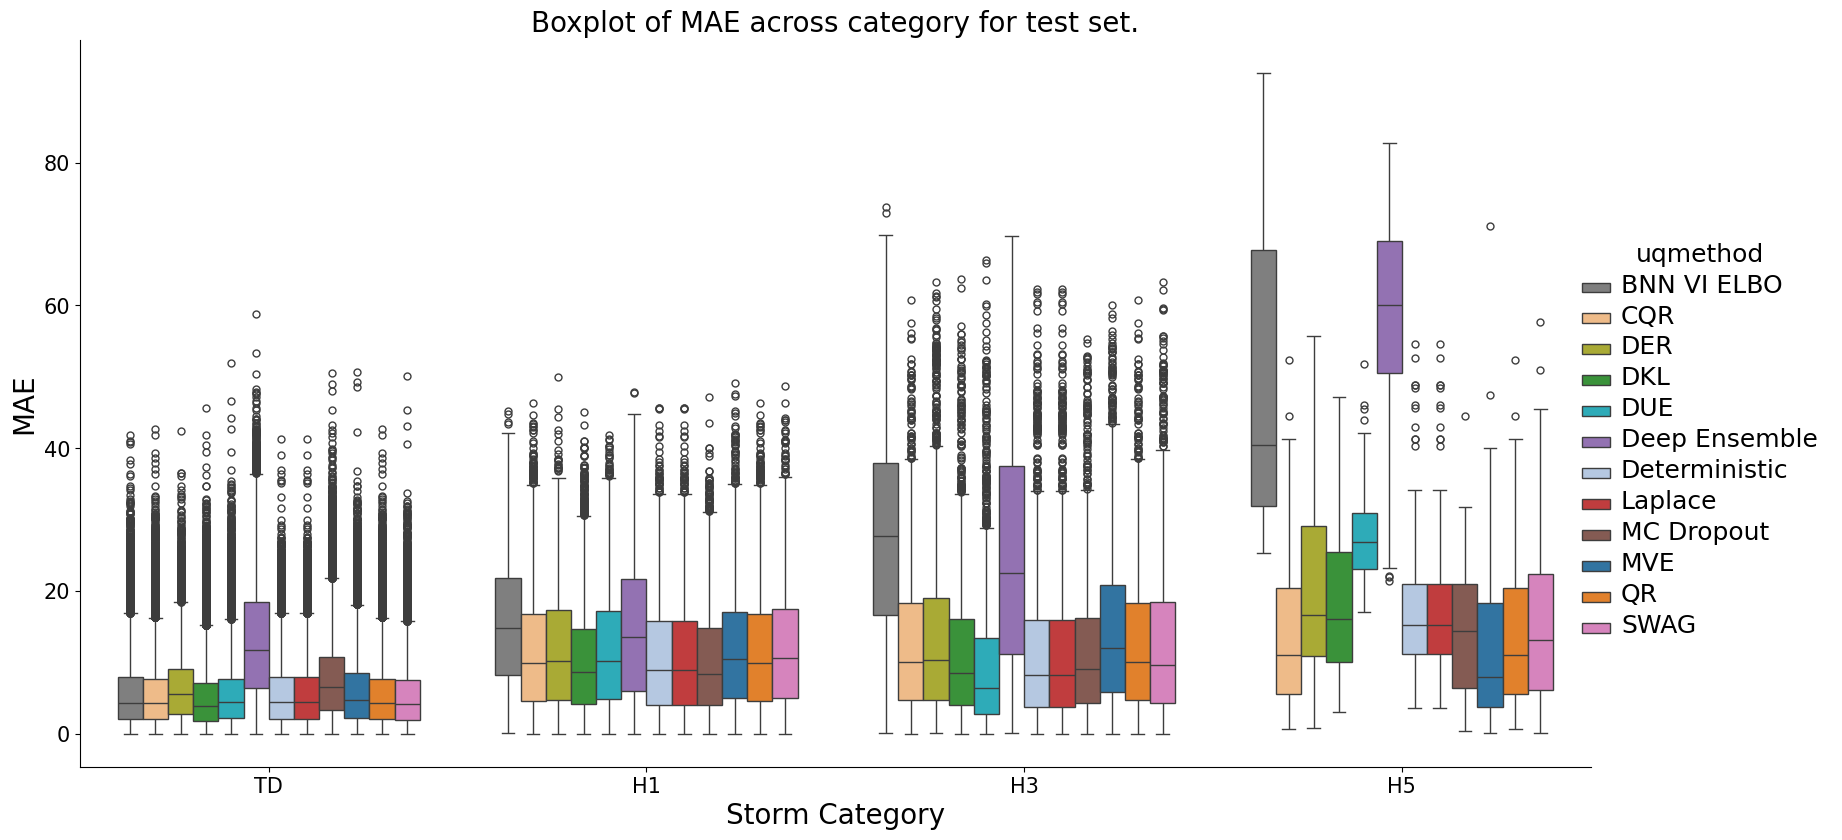

In [46]:
def plot_boxplot(all_test_pred_df, split, metric):
    plot_df = all_test_pred_df[all_test_pred_df["split"]==f"preds_{split}"]
    # remove categories with no predictions
    mask = plot_df.groupby("storm_category", observed=False)[metric].transform(lambda x: x.isna().any())
    plot_df = plot_df[~mask]
    plot_df = plot_df[plot_df["storm_category"].isin(STORM_DISPLAY_ORDER)]
    plot_df["storm_category"] = plot_df["storm_category"].cat.remove_unused_categories()

    g = sns.catplot(plot_df, kind="box", x="storm_category", y=metric, hue="uqmethod", height=8, aspect=2, palette=color_palette)

    ax = g.ax

    # Add horizontal lines behind each x value group
    for i, artist in enumerate(ax.artists):
        if i % 2 == 0:  # Check if it's an even index (i.e., group separator)
            artist.set_edgecolor('black')  # Set the edge color to black

    # Increase the size of the x and y ticks
    ax.tick_params(axis='both', which='major', labelsize=15)

    plt.title(f"Boxplot of {VAR_TO_PLOT_LABEL[metric]} across category for {split} set.", fontsize=20)
    plt.ylabel(f"{VAR_TO_PLOT_LABEL[metric]}", fontsize=20)
    plt.xlabel("Storm Category", fontsize=20)

    # Replace the uqmethod labels in the legend using the VAR_TO_PLOT_LABEL dictionary
    for t in g._legend.texts:
        t.set_text(VAR_TO_PLOT_LABEL[t.get_text()] if t.get_text() in VAR_TO_PLOT_LABEL else t.get_text())

    plt.setp(g._legend.get_texts(), fontsize='18') # for legend text
    plt.setp(g._legend.get_title(), fontsize='18') # for legend title
    g._legend.set_bbox_to_anchor((1.0, 0.5))

# Call the function with 'val' or 'train' as the split argument and 'mae' or any other metric as the metric argument
plot_boxplot(all_test_pred_df, DS_SPLIT, 'mae')

# Selective prediction per Storm Category

In [47]:
from sklearn.metrics import mean_squared_error


def generate_summary_table(all_test_pred_df, split):
    # Compute RMSE for all samples per uqmethod
    rmse_all_samples = all_test_pred_df[all_test_pred_df["split"]==f"preds_{split}"].groupby('uqmethod', observed=False).apply(lambda x: np.sqrt(mean_squared_error(x['pred'], x['target']))).reset_index()
    rmse_all_samples.columns = ['uqmethod', 'RMSE_All']

    # Add the "all" category
    rmse_all_samples['storm_category'] = 'all'

    # Compute RMSE per method and category
    rmse_all = all_test_pred_df[all_test_pred_df["split"]==f"preds_{split}"].groupby(['uqmethod', 'storm_category'], observed=False).apply(lambda x: np.sqrt(mean_squared_error(x['pred'], x['target']))).reset_index()
    rmse_all.columns = ['uqmethod', 'storm_category', 'RMSE_All']

    # Append the new rows to the RMSE_All DataFrame
    rmse_all = pd.concat([rmse_all, rmse_all_samples], ignore_index=True)

    # Filter data where uncertainty is less than the threshold
    df_filtered = all_test_pred_df[all_test_pred_df["uqmethod"]!="DeterministicRegression"].groupby(['pred_path', 'storm_category'], observed=False).apply(
        lambda group: group[group['pred_uct'] < SELECTIVE_PRED_DICT[os.path.dirname(group.name[0])][group.name[1]]]
    ).reset_index(drop=True)

    rmse_all_samples_filtered = df_filtered.groupby('uqmethod', observed=False).apply(lambda x: np.sqrt(mean_squared_error(x['pred'], x['target']))).reset_index()
    rmse_all_samples_filtered.columns = ['uqmethod', 'RMSE_Uncertainty_Less_Threshold']

    # Add the "all" category
    rmse_all_samples_filtered['storm_category'] = 'all'

    # Compute RMSE per method and category for the filtered DataFrame
    rmse_filtered = df_filtered.groupby(['uqmethod', 'storm_category'], observed=False).apply(lambda x: np.sqrt(mean_squared_error(x['pred'], x['target']))).reset_index()
    rmse_filtered.columns = ['uqmethod', 'storm_category', 'RMSE_Uncertainty_Less_Threshold']

    # Append the new rows to the RMSE_Uncertainty_Less_Threshold DataFrame
    rmse_filtered = pd.concat([rmse_filtered, rmse_all_samples_filtered], ignore_index=True)

    # Merge the two DataFrames on method and category
    summary_table = pd.merge(rmse_all, rmse_filtered, on=['uqmethod', 'storm_category'], how='left')

    # If there are some categories/methods where no data meets the threshold condition, you might want to replace NaNs with a specific value
    summary_table.fillna({'RMSE_Uncertainty_Less_Threshold': np.nan}, inplace=True)

    summary_table['pct_change'] = ((summary_table['RMSE_Uncertainty_Less_Threshold'] - summary_table['RMSE_All']) / summary_table['RMSE_All']) * 100
    summary_table["abs_change"] = np.abs(summary_table['RMSE_Uncertainty_Less_Threshold'] - summary_table['RMSE_All'])
    summary_table['abs_change'] = summary_table['abs_change'].fillna(0)

    return summary_table

# Call the function with 'val' or 'train' as the argument
summary_table = generate_summary_table(all_test_pred_df, DS_SPLIT)
print(summary_table)

                  uqmethod storm_category   RMSE_All  \
0   BNN_VI_ELBO_Regression             TD   7.558650   
1   BNN_VI_ELBO_Regression             TS   9.160650   
2   BNN_VI_ELBO_Regression             H1  17.779151   
3   BNN_VI_ELBO_Regression             H2  24.628159   
4   BNN_VI_ELBO_Regression             H3  31.559626   
..                     ...            ...        ...   
91       LaplaceRegression            all   9.691237   
92     MCDropoutRegression            all  10.661406   
93           MVERegression            all  10.699282   
94      QuantileRegression            all  10.124168   
95          SWAGRegression            all  10.250534   

    RMSE_Uncertainty_Less_Threshold  pct_change  abs_change  
0                          6.154241  -18.580160    1.404409  
1                          7.569153  -17.373190    1.591497  
2                         18.055986    1.557078    0.276835  
3                         30.481417   23.766529    5.853258  
4                

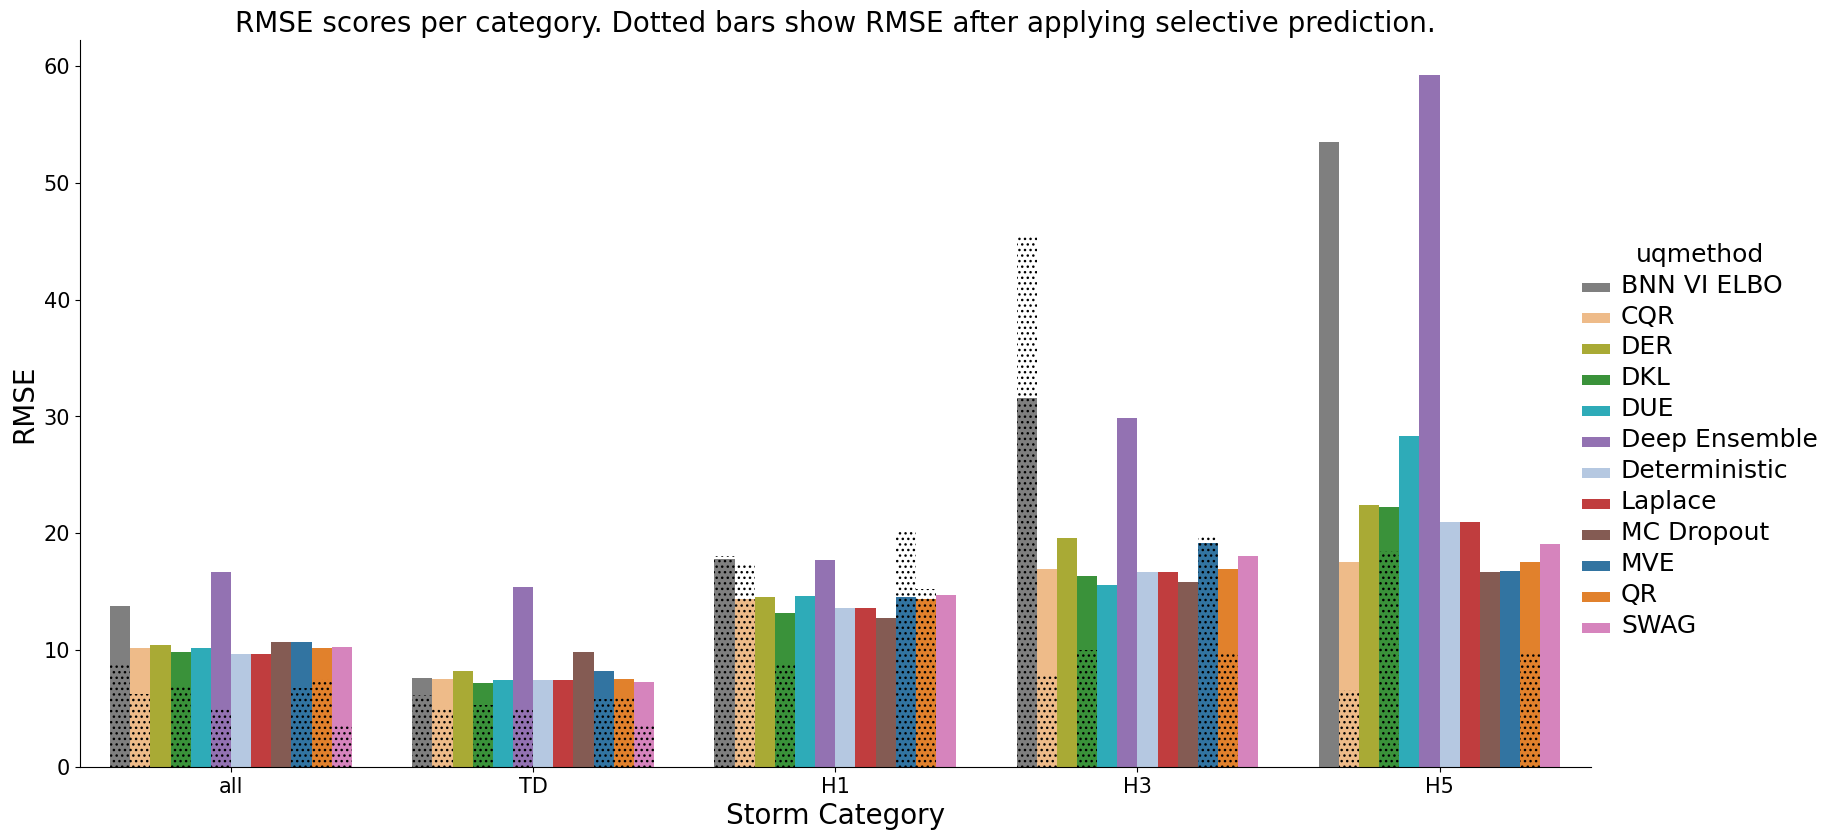

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_bar(summary_table):
    # Convert the storm_category column to 'category' dtype
    summary_table["storm_category"] = summary_table["storm_category"].astype('category')

    # Now you can use the cat accessor
    summary_table["storm_category"] = summary_table["storm_category"].cat.remove_unused_categories()

    hue_order = summary_table["uqmethod"].unique().tolist()

    # remove categories with no predictions
    summary_table["storm_category"] = summary_table["storm_category"].cat.remove_unused_categories()

    summary_table = summary_table[summary_table["storm_category"].isin(STORM_DISPLAY_ORDER)]

    # Use the order parameter in the catplot function
    g = sns.catplot(data=summary_table, kind="bar", x="storm_category", y="RMSE_All", hue="uqmethod", height=8, aspect=2, palette=color_palette, hue_order=hue_order, order=STORM_DISPLAY_ORDER)

    ax = g.ax

    sns.barplot(data=summary_table, x="storm_category", y="RMSE_Uncertainty_Less_Threshold", hue="uqmethod", alpha=0.0, ax=ax, hatch="...", hue_order=hue_order, order=STORM_DISPLAY_ORDER)

    ax.get_legend().remove()

    # Increase the size of the x and y ticks
    ax.tick_params(axis='both', which='major', labelsize=15)

    # Replace the uqmethod labels in the legend using the VAR_TO_PLOT_LABEL dictionary
    for t in g._legend.texts:
        t.set_text(VAR_TO_PLOT_LABEL[t.get_text()] if t.get_text() in VAR_TO_PLOT_LABEL else t.get_text())
    plt.title("RMSE scores per category. Dotted bars show RMSE after applying selective prediction.", fontsize=20)
    plt.ylabel("RMSE", fontsize=20)
    plt.xlabel("Storm Category", fontsize=20)

    plt.setp(g._legend.get_texts(), fontsize='18') # for legend text
    plt.setp(g._legend.get_title(), fontsize='18') # for legend title
    g._legend.set_bbox_to_anchor((1.0, 0.5))

# Call the function with the summary table as the argument
plot_bar(summary_table)


In [49]:
def compute_summary(all_test_pred_df, split):

    rmse_all_samples = all_test_pred_df[all_test_pred_df["split"]==f"preds_{split}"].groupby('uqmethod', observed=False).apply(lambda x: np.mean(x["pred_uct"])).reset_index()
    rmse_all_samples.columns = ['uqmethod', 'SHARP_All']

    # Add the "all" category
    rmse_all_samples['storm_category'] = 'all'

    # Compute RMSE per method and category
    rmse_all = all_test_pred_df[all_test_pred_df["split"]==f"preds_{split}"].groupby(['uqmethod', 'storm_category'], observed=False).apply(lambda x: np.mean(x["pred_uct"])).reset_index()
    rmse_all.columns = ['uqmethod', 'storm_category', 'SHARP_All']

    # Append the new rows to the RMSE_All DataFrame
    rmse_all = pd.concat([rmse_all, rmse_all_samples], ignore_index=True)

    # Filter data where uncertainty is less than the threshold
    df_filtered = all_test_pred_df[all_test_pred_df["uqmethod"]!="DeterministicRegression"].groupby(['pred_path', 'storm_category'], observed=False).apply(
        lambda group: group[group['pred_uct'] < SELECTIVE_PRED_DICT[os.path.dirname(group.name[0])][group.name[1]]]
    ).reset_index(drop=True)

    # Compute RMSE per method and category over filtered predictions
    rmse_filtered = df_filtered.groupby(['uqmethod', 'storm_category'], observed=False).apply(lambda x: np.mean(x["pred_uct"])).reset_index()
    rmse_filtered.columns = ['uqmethod', 'storm_category', 'SHARP_Uncertainty_Less_Threshold']

    # Merge the two DataFrames on method and category
    summary_table = pd.merge(rmse_all, rmse_filtered, on=['uqmethod', 'storm_category'], how='left')

    # If there are some categories/methods where no data meets the threshold condition, you might want to replace NaNs with a specific value
    summary_table.fillna({'SHARP_Uncertainty_Less_Threshold': np.nan}, inplace=True)

    summary_table['pct_change'] = ((summary_table['SHARP_Uncertainty_Less_Threshold'] - summary_table['SHARP_All']) / summary_table['SHARP_All']) * 100
    summary_table["abs_change"] = np.abs(summary_table['SHARP_Uncertainty_Less_Threshold'] - summary_table['SHARP_All'])
    summary_table['abs_change'] = summary_table['abs_change'].fillna(0)

    return summary_table

# Call the function with all_test_pred_df DataFrame and 'val' or 'train' as the split argument
summary_table = compute_summary(all_test_pred_df, DS_SPLIT)

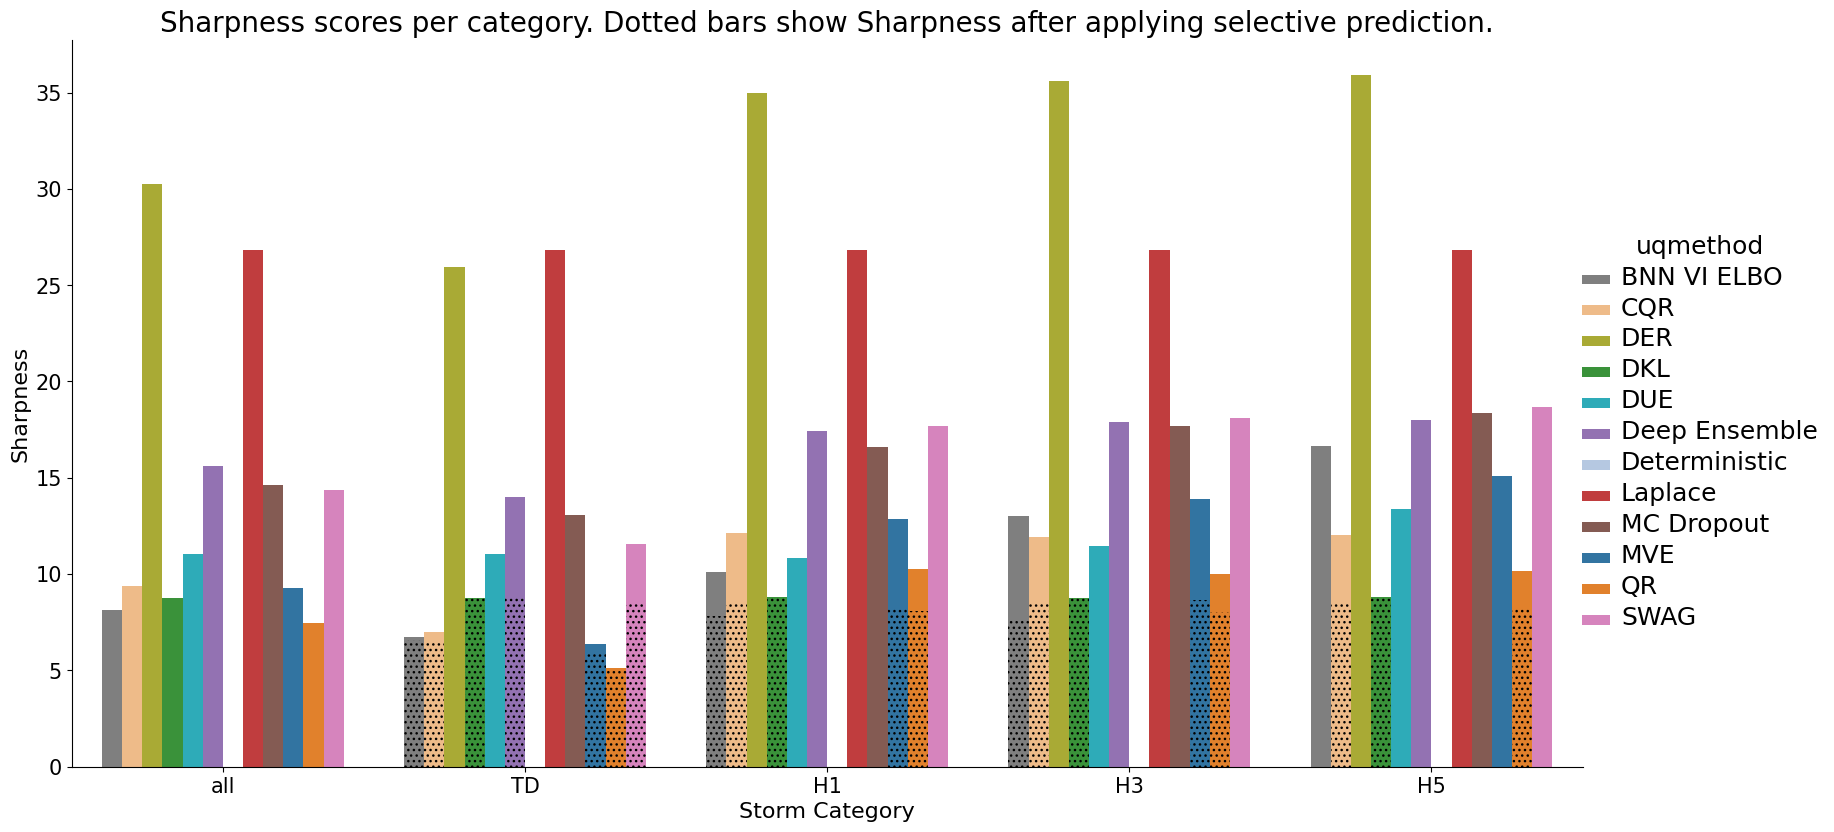

In [50]:
def plot_sharpness(summary_table):
    summary_table["storm_category"] = summary_table["storm_category"].astype('category')
    hue_order = summary_table[summary_table["uqmethod"]!="DERModel"]["uqmethod"].unique().tolist()
    summary_table["storm_category"] = summary_table["storm_category"].cat.remove_unused_categories()
    summary_table = summary_table[summary_table["storm_category"].isin(STORM_DISPLAY_ORDER)]

    g = sns.catplot(data=summary_table[summary_table["uqmethod"]!="DERModel"], kind="bar", x="storm_category", y="SHARP_All", hue="uqmethod", height=8, aspect=2, palette=color_palette, hue_order=hue_order, order=STORM_DISPLAY_ORDER)

    ax = g.ax

    sns.barplot(data=summary_table, x="storm_category", y="SHARP_Uncertainty_Less_Threshold", hue="uqmethod", alpha=0.0, ax=ax, hatch="...", hue_order=hue_order, order=STORM_DISPLAY_ORDER)

    ax.get_legend().remove()

    # Increase the size of the x and y ticks
    ax.tick_params(axis='both', which='major', labelsize=15)

    # Replace the uqmethod labels in the legend using the VAR_TO_PLOT_LABEL dictionary
    for t in g._legend.texts:
        t.set_text(VAR_TO_PLOT_LABEL[t.get_text()] if t.get_text() in VAR_TO_PLOT_LABEL else t.get_text())

    plt.title("Sharpness scores per category. Dotted bars show Sharpness after applying selective prediction.", fontsize=20)
    plt.ylabel("Sharpness", fontsize=16)
    plt.xlabel("Storm Category", fontsize=16)
    plt.setp(g._legend.get_texts(), fontsize='18') # for legend text
    plt.setp(g._legend.get_title(), fontsize='18') # for legend title
    g._legend.set_bbox_to_anchor((1.0, 0.5))

# Call the function with the summary table as the argument
plot_sharpness(summary_table)

# Calibration

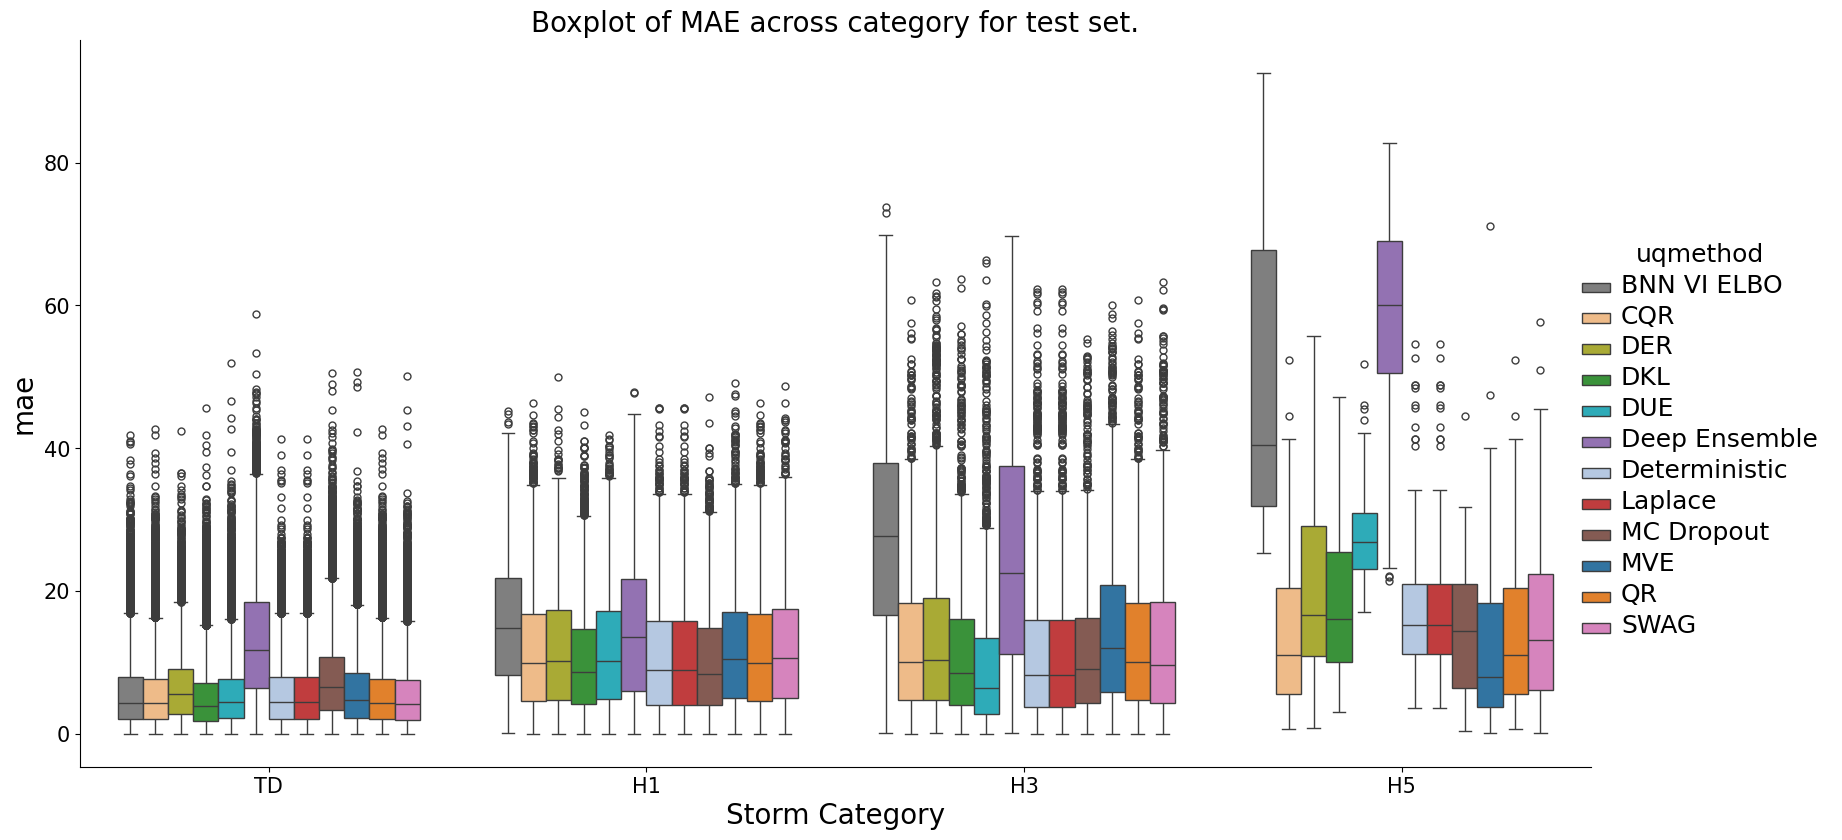

In [51]:
def plot_boxplot(all_test_pred_df, split, metric):
    plot_df = all_test_pred_df[all_test_pred_df["split"]==f"preds_{split}"]
    # remove categories with no predictions
    mask = plot_df.groupby("storm_category", observed=False)[metric].transform(lambda x: x.isna().any())
    plot_df = plot_df[~mask]
    plot_df = plot_df[plot_df["storm_category"].isin(STORM_DISPLAY_ORDER)]
    plot_df["storm_category"] = plot_df["storm_category"].cat.remove_unused_categories()
    g = sns.catplot(plot_df, kind="box", x="storm_category", y=metric, hue="uqmethod", height=8, aspect=2, palette=color_palette)

    ax = g.ax

    # Add horizontal lines behind each x value group
    for i, artist in enumerate(ax.artists):
        if i % 2 == 0:  # Check if it's an even index (i.e., group separator)
            artist.set_edgecolor('black')  # Set the edge color to black



    # Increase the size of the x and y ticks
    ax.tick_params(axis='both', which='major', labelsize=15)

    # Replace the uqmethod labels in the legend using the VAR_TO_PLOT_LABEL dictionary
    for t in g._legend.texts:
        t.set_text(VAR_TO_PLOT_LABEL[t.get_text()] if t.get_text() in VAR_TO_PLOT_LABEL else t.get_text())

    plt.title(f"Boxplot of {VAR_TO_PLOT_LABEL[metric]} across category for {split} set.", fontsize=20)
    plt.ylabel(f"{metric}", fontsize=20)
    plt.xlabel("Storm Category", fontsize=20)
    plt.setp(g._legend.get_texts(), fontsize='18') # for legend text
    plt.setp(g._legend.get_title(), fontsize='18') # for legend title
    g._legend.set_bbox_to_anchor((1.0, 0.5))

# Call the function with 'val' or 'train' as the split argument and 'mae' or any other metric as the metric argument
plot_boxplot(all_test_pred_df, DS_SPLIT, 'mae')

In [ ]:
from typing import Union, List, Any
from matplotlib.axes import Axes
from uncertainty_toolbox.metrics_calibration import (
    get_proportion_lists,
    get_proportion_lists_vectorized,
    adversarial_group_calibration,
    miscalibration_area,
    miscalibration_area_from_proportions,
)


def filter_subset(input_list: List[List[Any]], n_subset: int) -> List[List[Any]]:
    """Keep only n_subset random indices from all lists given in input_list.

    Args:
        input_list: list of lists.
        n_subset: Number of points to plot after filtering.

    Returns:
        List of all input lists with sizes reduced to n_subset.
    """
    assert type(n_subset) is int
    n_total = len(input_list[0])
    idx = np.random.choice(range(n_total), n_subset, replace=False)
    idx = np.sort(idx)
    output_list = []
    for inp in input_list:
        outp = inp[idx]
        output_list.append(outp)
    return output_list


# TODO Look up color pallete value
def plot_calibration(
    y_pred: np.ndarray,
    y_std: np.ndarray,
    y_true: np.ndarray,
    split_name: str,
    n_subset: Union[int, None] = None,
    curve_label: Union[str, None] = None,
    vectorized: bool = True,
    exp_props: Union[np.ndarray, None] = None,
    obs_props: Union[np.ndarray, None] = None,
    ax: Union[Axes, None] = None,
    prop_type: str = "interval",
) -> Axes:
    """Plot the observed proportion vs prediction proportion of outputs falling into a
    range of intervals, and display miscalibration area.

    Args:
        y_pred: 1D array of the predicted means for the held out dataset.
        y_std: 1D array of the predicted standard deviations for the held out dataset.
        y_true: 1D array of the true labels in the held out dataset.
        n_subset: Number of points to plot after filtering.
        curve_label: legend label str for calibration curve.
        vectorized: plot using get_proportion_lists_vectorized.
        exp_props: plot using the given expected proportions.
        obs_props: plot using the given observed proportions.
        ax: matplotlib.axes.Axes object.
        prop_type: "interval" to measure observed proportions for centered prediction intervals,
                   and "quantile" for observed proportions below a predicted quantile.
                   Ignored if exp_props and obs_props are provided as inputs.

    Returns:
        matplotlib.axes.Axes object with plot added.
    """
    # Create ax if it doesn't exist
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))

    # Optionally select a subset
    if n_subset is not None:
        [y_pred, y_std, y_true] = filter_subset([y_pred, y_std, y_true], n_subset)

    if (exp_props is None) or (obs_props is None):
        # Compute exp_proportions and obs_proportions
        if vectorized:
            (exp_proportions, obs_proportions) = get_proportion_lists_vectorized(
                y_pred, y_std, y_true, prop_type=prop_type
            )
        else:
            (exp_proportions, obs_proportions) = get_proportion_lists(
                y_pred, y_std, y_true, prop_type=prop_type
            )
    else:
        # If expected and observed proportions are given
        exp_proportions = np.array(exp_props).flatten()
        obs_proportions = np.array(obs_props).flatten()
        if exp_proportions.shape != obs_proportions.shape:
            raise RuntimeError("exp_props and obs_props shape mismatch")

    # Set label
    if curve_label is None:
        curve_label = "Predictor"

    # Plot
    ax.plot([0, 1], [0, 1], "--", c="gray")
    ax.plot(
        exp_proportions, obs_proportions, label=curve_label.replace("Model", ""), c=color_palette[curve_label]
    )  # , c="#1f77b4")
    # ax.fill_between(exp_proportions, exp_proportions, obs_proportions, alpha=0.1)

    # Format plot
    ax.set_xlabel("Predicted Proportion in Interval", fontsize=16)
    ax.set_ylabel("Observed Proportion in Interval", fontsize=16)
    ax.axis("square")

    buff = 0.01
    ax.set_xlim([0 - buff, 1 + buff])
    ax.set_ylim([0 - buff, 1 + buff])

    ax.set_title(f"Avg Calibration {split_name}", fontsize=16)

    # Compute miscalibration area
    miscalibration_area = miscalibration_area_from_proportions(
        exp_proportions=exp_proportions, obs_proportions=obs_proportions
    )

    # Annotate plot with the miscalibration area
    # ax.text(
    #     x=0.95,
    #     y=0.05,
    #     s="Miscalibration area = %.2f" % miscalibration_area,
    #     verticalalignment="bottom",
    #     horizontalalignment="right",
    #     fontsize="small",
    # )

    return ax

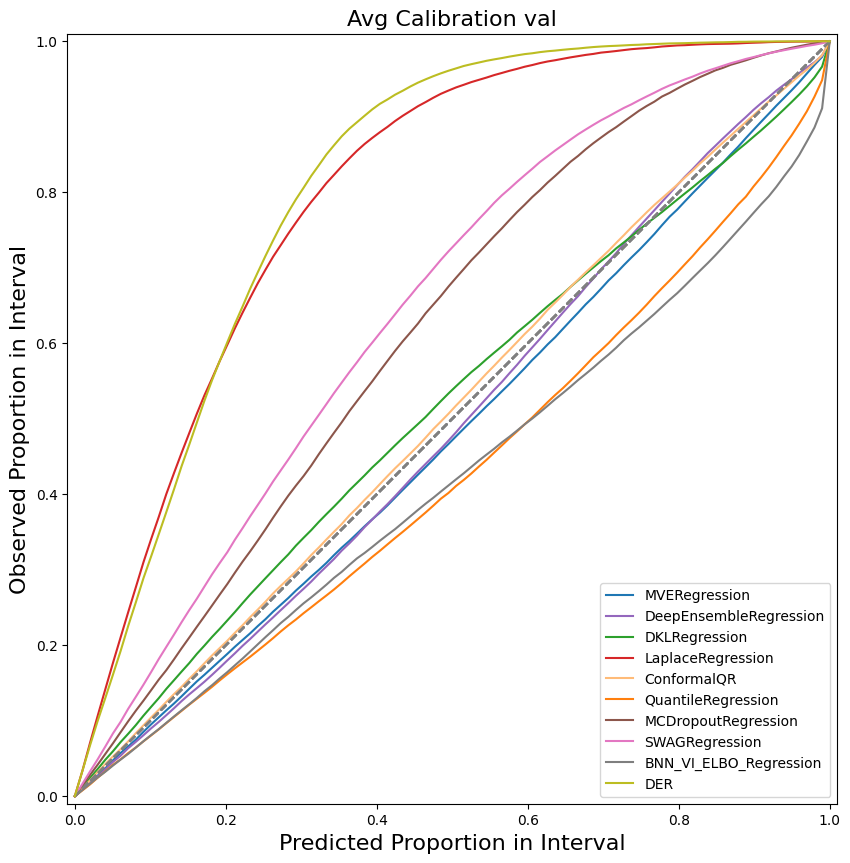

In [ ]:
uq_methods_to_show = [
    "MVERegression",
    "DeepEnsembleRegression",
    "DKLRegression",
    "LaplaceRegression",
    "ConformalQR",
    "QuantileRegression",
    "MCDropoutRegression",
    "SWAGRegression",
    "BNN_VI_ELBO_Regression",
    "DER",
]

split = "val"

fig, axs = plt.subplots(1, figsize=(10,10))
for idx_uq, uq_method in enumerate(uq_methods_to_show):
    plot_df = uq_metric_df[uq_metric_df["uqmethod"] == uq_method].copy()
    plot_df = plot_df[plot_df["split"]==f"preds_{DS_SPLIT}"]
    plot_df.sort_values(by="split", inplace=True)
    plot_df.reset_index(inplace=True)
    # for idx, pred_path in enumerate(plot_df["pred_path"].unique()):
    for idx, row in plot_df.iterrows():
        split_df = pd.read_csv(row["pred_path"])
        if "pred_uct" in split_df.columns:
            plot_calibration(
                split_df["pred"].values.squeeze(),
                split_df["pred_uct"].values.squeeze(),
                split_df["target"].values.squeeze(),
                ax=axs,
                curve_label=uq_method,
                split_name=split
            )
plt.legend()

# Correlation between Predictive Uncertainty and Errors

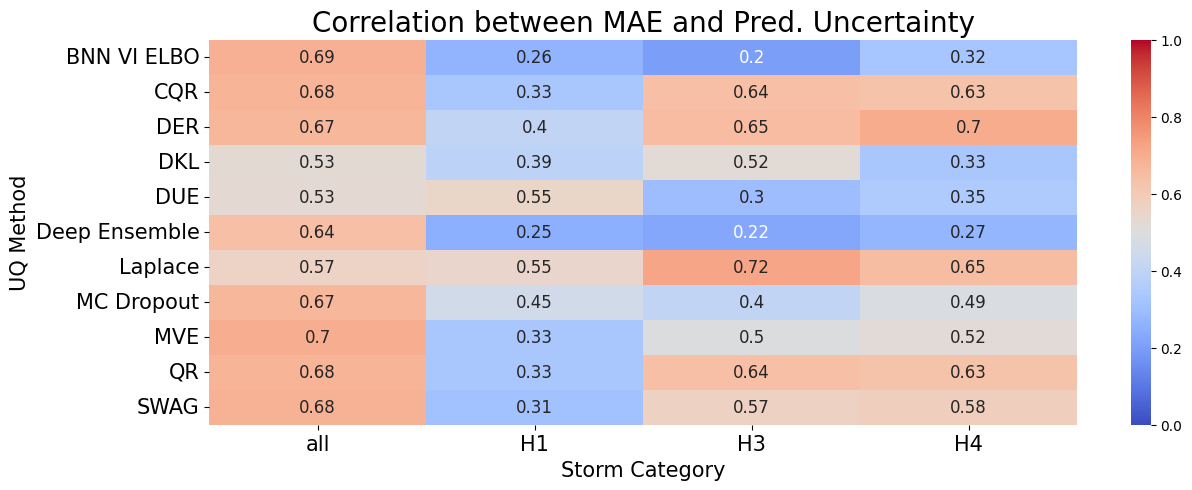

In [ ]:
def plot_correlation_heatmap(all_test_pred_df, split, corr_one, corr_two):

    filtered_df = all_test_pred_df[(all_test_pred_df["split"]==f"preds_{split}") & (all_test_pred_df["uqmethod"]!="DeterministicRegression")]

    # Compute the correlation matrix
    corr_df = filtered_df.groupby(['uqmethod', 'storm_category'], observed=False).apply(lambda group: group[[corr_one, corr_two]].corr()).reset_index()

    # Compute the aggregate correlation
    aggregate_corr_df = filtered_df.groupby('uqmethod', observed=False).apply(lambda group: group[[corr_one, corr_two]].corr()).reset_index()

    # Add a 'storm_category' column to the aggregate correlation DataFrame
    aggregate_corr_df['storm_category'] = 'all'

    # Append the aggregate correlation to the correlation DataFrame
    corr_df = pd.concat([corr_df, aggregate_corr_df], ignore_index=True)

    # Create a pivot table with 'uqmethod' and 'storm_category' as the index and columns, and the correlation between 'pred_uct' and 'mae' as the values
    pivot_table = corr_df.pivot_table(index='uqmethod', columns='storm_category', values='mae')

    pivot_table = pivot_table.reindex(STORM_DISPLAY_ORDER, axis=1)

    # Create a heatmap from the pivot table
    sns.heatmap(pivot_table, annot=True, cmap='coolwarm', vmin=0, vmax=1,annot_kws={'fontsize': 12})

    # Set the title and increase the size of the labels
    plt.title(f'Correlation between {VAR_TO_PLOT_LABEL[corr_one]} and {VAR_TO_PLOT_LABEL[corr_two]}', fontsize=20)
    plt.xlabel('Storm Category', fontsize=15)
    plt.ylabel('UQ Method', fontsize=15)

    # Increase the size of the tick labels
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

    # Replace the y-tick labels using the VAR_TO_PLOT_LABEL dictionary
    yticklabels = [VAR_TO_PLOT_LABEL[label.get_text()] if label.get_text() in VAR_TO_PLOT_LABEL else label.get_text() for label in plt.gca().get_yticklabels()]
    plt.gca().set_yticklabels(yticklabels)

    # Show the plot
    plt.show()

# Call the function with the all_test_pred_df DataFrame, 'val' as the split argument, and 'mae' and 'pred_uct' as the correlation arguments
plot_correlation_heatmap(all_test_pred_df, DS_SPLIT, 'mae', 'pred_uct')

# Data Exploration

In [ ]:
from tropical_cyclone_ds import TropicalCycloneSequence

path = "/p/project/hai_uqmethodbox/data/tropical_cyclone"

train_ds = TropicalCycloneSequence(root=path)

Num samples: 69269


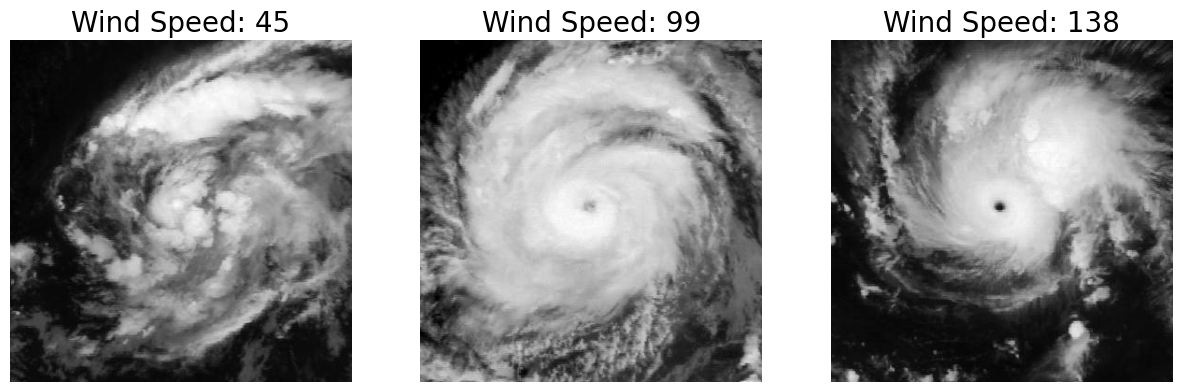

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


ranges = [CLASS_BINS["TS"], CLASS_BINS["H3"], CLASS_BINS["H5"]]

# Create a subplot to display the images
# fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# for i, (min_speed, max_speed) in enumerate(ranges):
#     # Iterate through the dataset until you find a sample in the current wind speed range
#     for idx, sample in tqdm(enumerate(train_ds)):
        
#         if min_speed <= int(sample["target"]) < max_speed:
#             print(idx)
#             break
    
#     image = sample["input"].numpy().transpose(1, 2, 0) / 255
    
#     # Display the image and set the title to the target value
#     axes[i].imshow(image, cmap='gray')
#     axes[i].set_title(f'Wind Speed: {int(sample["target"])}')
#     axes[i].axis('off')

# plt.show()

# Define the indices of the samples you need
indices = [0, 2646, 2555]

# Create a subplot to display the images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, index in enumerate(indices):
    # Retrieve the sample from the dataset
    sample = train_ds[index]
    
    image = sample["input"].numpy().transpose(1, 2, 0)[...,0] / 255
    
    # Display the image and set the title to the target value
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f'Wind Speed: {int(sample["target"])}', fontsize=20)
    axes[i].axis('off')

plt.show()

In [ ]:
def retrieve_item(item, ds):
    source_id = item["href"].split("/")[0]
    if "train_source" in source_id:
        split = "train"
    else:
        split = "test"

    directory = os.path.join(
        ds.root,
        "_".join([train_ds.collection_id, split, "{0}"]),
        source_id.replace("source", "{0}"),
    )
    features = ds._load_features(directory)
    data = {"path": source_id, **features}
    # don't nee the tensor label, already includes 'wind_speed'
    data.pop("label")
    # but add original split where it is coming from
    data["split"] = split
    return data

def retrieve_collection_df(ds):
    def parallel_process(items, ds, num_processes: int):
        # Create a multiprocessing pool with the specified number of processes
        pool = Pool(processes=num_processes)
        # Map the paths to the process_path function and execute in parallel
        read_items = pool.starmap(retrieve_item, [(item, ds) for item in items])
        # Close the pool of processes
        pool.close()
        # Combine the resulting DataFrames into a single DataFrame
        df = pd.DataFrame.from_dict(read_items)
        return df
    
    # Specify the number of processes to use for parallel execution
    num_processes = 8  # Adjust according to your system capabilities
    items = [item for item in ds.collection]
    # Call the parallel_process function to execute the processing in parallel
    df = parallel_process(items, ds, num_processes)

    return df

In [ ]:
train_df = retrieve_collection_df(train_ds)
train_df["wind_speed"] = train_df["wind_speed"].astype(int)

In [ ]:
train_df['storm_category'] = pd.cut(train_df['wind_speed'], bins=BIN_EDGES, labels=CLASS_LABELS, right=False)
train_df

,path,storm_id,relative_time,ocean,wind_speed,split,storm_category
0,nasa_tropical_storm_competition_train_source_n...,nhe,0,2,34,train,TS
1,nasa_tropical_storm_competition_train_source_n...,nhe,1800,2,34,train,TS
2,nasa_tropical_storm_competition_train_source_n...,nhe,3600,2,34,train,TS
3,nasa_tropical_storm_competition_train_source_n...,nhe,5402,2,33,train,TS
4,nasa_tropical_storm_competition_train_source_n...,nhe,9001,2,32,train,TD
...,...,...,...,...,...,...,...
70252,nasa_tropical_storm_competition_train_source_y...,yti,255601,1,45,train,TS
70253,nasa_tropical_storm_competition_train_source_y...,yti,259201,1,45,train,TS
70254,nasa_tropical_storm_competition_train_source_y...,yti,262801,1,45,train,TS
70255,nasa_tropical_storm_competition_train_source_y...,yti,266401,1,45,train,TS


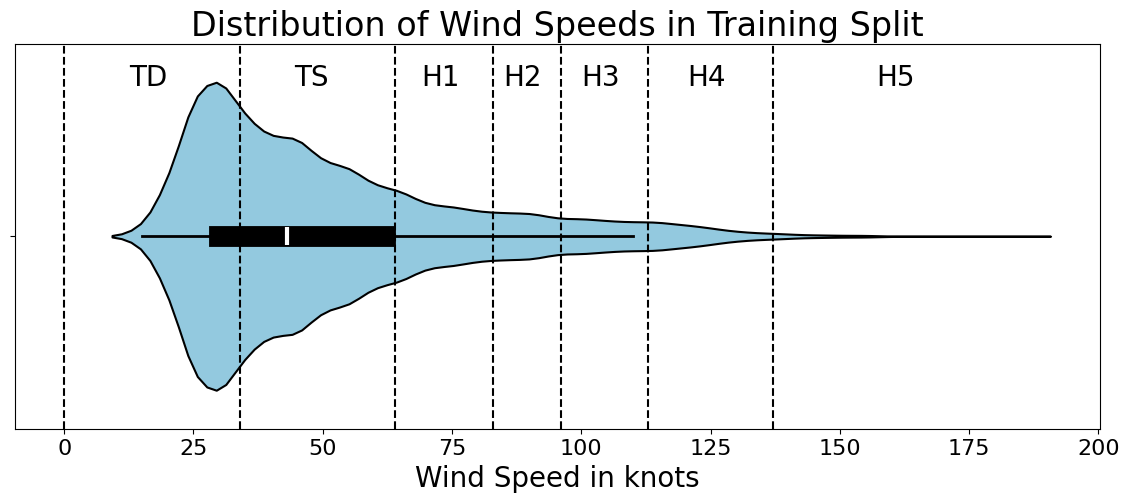

In [ ]:
import seaborn as sns


CLASS_BINS = {
    "TD": (0, 33),
    "TS": (34, 63),
    "H1": (64, 82),
    "H2": (83, 95),
    "H3": (96, 112),
    "H4": (113, 136),
    "H5": (137, np.inf),
}

CLASS_BINS["H5"] = (137, train_df['wind_speed'].max())

# Create a horizontal violin plot of the wind_speed variable
sns.violinplot(x=train_df['wind_speed'], orient='h', color='skyblue', inner_kws=dict(box_width=15, whis_width=2, color="black"),linewidth=1.5, linecolor="k" )

# Add vertical lines to represent the boundaries of the storm categories
# Add vertical lines to represent the boundaries of the storm categories
for category, (min_speed, max_speed) in CLASS_BINS.items():
    midpoint = (min_speed + max_speed) / 2 - 4
    plt.axvline(x=min_speed, color='black', linestyle='--')
    plt.text(midpoint, plt.gca().get_ylim()[1]*0.9, category, color='black', fontsize=20, verticalalignment='top')

# Add labels and title with larger font size
plt.xlabel('Wind Speed in knots', fontsize=20)
plt.title('Distribution of Wind Speeds in Training Split', fontsize=24)

# Increase the size of the x-ticks
plt.xticks(fontsize=16)

# Show the plot
plt.show()


In [ ]:
full_df = pd.concat([train_df, test_df], ignore_index=True)
full_df["wind_speed"] = full_df["wind_speed"].astype(int)

full_df['storm_category'] = pd.cut(full_df['wind_speed'], bins=bins, labels=labels, right=False)
full_df
                     

NameError: name 'test_df' is not defined

## Wind Speed across splits

In [ ]:
fig, axs = plt.subplots(1)
sns.violinplot(full_df, x="split", y="wind_speed", ax=axs)
axs.set_title("Wind Speed for train and test split.")

## Wind Speed across categories

In [ ]:
# fig, axs = plt.subplots(1)
sns.catplot(full_df, kind="box", x="storm_category", y="wind_speed", hue="split")
plt.title("Boxplot of wind speeds across category and split")

In [ ]:
fig, axs = plt.subplots(1)
sns.countplot(full_df, x="storm_category", hue="split", ax=axs)
plt.title("Count samples per storm category")

In [ ]:
train_df["wind_speed"].astype(int).values

In [ ]:
np.save("/p/project/hai_uqmethodbox/nils/lightning-uq-box/experiments/image-regression/configs/tropical_cyclone/target.npy", (train_df["wind_speed"].astype(float).values - TARGET_MEAN) / TARGET_STD)